# Setting up the environment

In [90]:
# This sets up the required packages so that we are able to connect to a PostgreSQL database
import sys
!conda install --yes --prefix {sys.prefix} ipython-sql
!conda install --yes --prefix {sys.prefix} sqlalchemy
!conda install --yes --prefix {sys.prefix} psycopg2

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\mleev\AppData\Local\anaconda3

  added / updated specs:
    - ipython-sql


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2023.5.7~ --> pkgs/main::ca-certificates-2023.05.30-haa95532_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2023.5.7-~ --> pkgs/main/win-64::certifi-2023.5.7-py310haa95532_0 





Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


C:\Users\mleev\AppData\Local\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\mleev\AppData\Local\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\mleev\AppData\Local\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> WARN

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0




In [1]:
#Loads the ipython-sql package
%load_ext sql

#Uses the `create_engine` function
import configparser
from sqlalchemy import create_engine

config = configparser.ConfigParser()
config.read('config.cfg')  # Replace with the path to your config file

## Connecting to the ptc databse
# Retrieve the database credentials
username = config.get('PTC', 'username')
password = config.get('PTC', 'password')
host = config.get('PTC', 'host')
port = config.get('PTC', 'port')
database_name = config.get('PTC', 'database_name')

# Create the database connection URL
db_url = f'postgresql://{username}:{password}@{host}:{port}/{database_name}'

# Connect to the PostgreSQL database
engine = create_engine(db_url)


## Connecting to the bigdata database
# Retrieve the database credentials
username = config.get('BIGDATA', 'username')
password = config.get('BIGDATA', 'password')
host = config.get('BIGDATA', 'host')
port = config.get('BIGDATA', 'port')
database_name = config.get('BIGDATA', 'database_name')

# Create the database connection URL
weather_db_url = f'postgresql://{username}:{password}@{host}:{port}/{database_name}'

# Connect to the PostgreSQL database
engine_weather = create_engine(weather_db_url)


In [101]:
#Importing packages
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import warnings
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Initiating data
## Ridehailing data

### Querying the data

In [102]:

%%script false # Skips running this code due to long runtime# Filtered only to include only the relevant attributes for analysis later
# Dashed attributes [--] are the attributes that were removed
query = '''
    SELECT 
        to_date(passengerpickupdatetime::text, 'YYYY-MM-DD HH24:MI:SS') AS date_col,
        date_part('year', to_date(passengerpickupdatetime::text, 'YYYY-MM-DD HH24:MI:SS'))::int AS year_col,
        date_part('month', to_date(passengerpickupdatetime::text, 'YYYY-MM-DD HH24:MI:SS'))::int AS month_col,
        date_part('dow', to_date(passengerpickupdatetime::text, 'YYYY-MM-DD HH24:MI:SS'))::int AS dow_col,
        extract(hour FROM passengerpickupdatetime)::int AS hour_col
    FROM mlee.trips_tmu 
    WHERE 
        passengerpickupdatetime IS NOT NULL AND
        passengerdropoffdatetime IS NOT NULL
'''
trips_hours = pd.read_sql (query, engine)

Couldn't find program: 'false'


In [103]:
%%script false # Skips running this code due to long runtime
#Exported the table due to the long time needed to generate the table
trips_hours.to_csv(r'trips_hours.csv', index=False)

Couldn't find program: 'false'


In [104]:
# Read the CSV file into a DataFrame
trips_hours = pd.read_csv('trips_hours.csv')
trips_hours.head()

,date_col,year_col,month_col,dow_col,hour_col
0,2019-04-05,2019,4,5,1
1,2019-04-05,2019,4,5,1
2,2019-12-04,2019,12,3,9
3,2019-12-04,2019,12,3,9
4,2019-12-04,2019,12,3,9


### Aggregating the demand data by date

In [105]:
# Aggregate data by date, retaining some of the attribute details
trips_daily = trips_hours.groupby(['date_col', 'year_col', 'month_col','dow_col']).size().reset_index(name='count')
# Print the aggregated data
trips_daily.head()

,date_col,year_col,month_col,dow_col,count
0,2018-01-01,2018,1,1,117459
1,2018-01-02,2018,1,2,71315
2,2018-01-03,2018,1,3,74263
3,2018-01-04,2018,1,4,87415
4,2018-01-05,2018,1,5,117827


### Graphing the demand data by date

In [106]:
# Plot the original data
fig = px.line(
    trips_daily,
    x='date_col', 
    y='count'
    )
    
fig.update_layout(
    title='Daily Ridehail Trips', 
    width=1400,
    xaxis=dict(
        title='Date',
        #tickformat='%Y-%m',  # Format for displaying year and month
        dtick='M3'
    ),
    yaxis=dict(
        title='Daily Ridehail Trips'
    )
)
# Initial lockdown annotation
fig.add_shape(
    type='line',
    x0='2020-03-14',  
    x1='2020-03-14',
    y0=0, 
    y1=300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2020-03-14',
    y=250000,
    text='1st lockdown',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)

# Second lockdown annotation
fig.add_shape(
    type='line',
    x0='2020-11-23',  
    x1='2020-11-23',
    y0=0, 
    y1=300000,
    line=dict(
        color='grey',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2020-11-23',
    y=250000,
    text='2nd lockdown',
    showarrow=False,
    font=dict(
        color='grey',
        size=12
    ),
    xanchor='left'
)

# Reopening annotation
fig.add_shape(
    type='line',
    x0='2021-06-11',  
    x1='2021-06-11',
    y0=0, 
    y1=300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2021-06-11',
    y=250000,
    text='Gradual reopening',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)

# Further limited travel orders annotation
fig.add_shape(
    type='line',
    x0='2022-01-05',  
    x1='2022-01-05',
    y0=0, 
    y1=300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2022-01-05',
    y=250000,
    text='Limited travel orders ',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)
fig.show()

Included static image due to issues generating the dynamic graph in Github

![Daily Ridehail Trips](ridehail_daily.png)

### Removing and imputing outliers
There are very visible outliers just by viewing the line graph above.
To better identify these outliers, the dataset will be split into three different date ranges:
- [Range1] Pre-pandemic: 2018-01-01 to 2020-03-13 inclusive
- [Range2] General lockdown measures: 2020-03-14 to 2021-06-10 inclusive
- [Range3] Gradual reopening: 2021-06-11 to 2022-12-31 inclusive

Classify the `trips_daily` table based on the above date ranges

In [107]:
# Convert the 'date_col' column to datetime type
trips_daily['date_col'] = pd.to_datetime(trips_daily['date_col'])

# Create a new column 'date_class' based on the condition
trips_daily['date_class'] = ['range1' if date < pd.to_datetime('2020-03-14') 
                             else 'range2' if (date >= pd.to_datetime('2020-03-14') and date < pd.to_datetime('2021-06-11')) 
                             else 'range3' 
                             for date in trips_daily['date_col']]

# Print the updated DataFrame
trips_daily

,date_col,year_col,month_col,dow_col,count,date_class
0,2018-01-01,2018,1,1,117459,range1
1,2018-01-02,2018,1,2,71315,range1
2,2018-01-03,2018,1,3,74263,range1
3,2018-01-04,2018,1,4,87415,range1
4,2018-01-05,2018,1,5,117827,range1
...,...,...,...,...,...,...
1852,2023-01-27,2023,1,5,169456,range3
1853,2023-01-28,2023,1,6,163098,range3
1854,2023-01-29,2023,1,0,128725,range3
1855,2023-01-30,2023,1,1,119716,range3


### Generate boxplots for the three date ranges

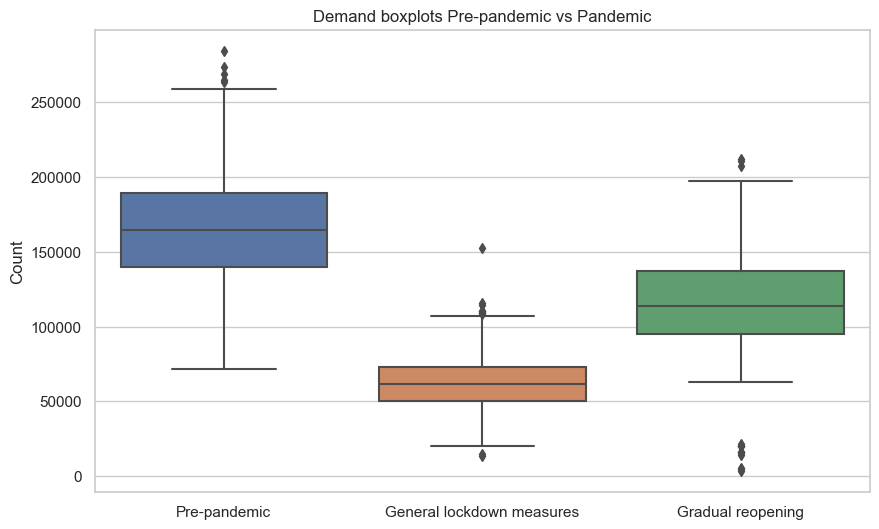

In [108]:
# Filter the data for 'Pre' and 'Post' date_class
range1_data = trips_daily[trips_daily['date_class'] == 'range1'][['date_col','count']]
range2_data = trips_daily[trips_daily['date_class'] == 'range2'][['date_col','count']]
range3_data = trips_daily[trips_daily['date_class'] == 'range3'][['date_col','count']]

# Combine the data for both 'Pre' and 'Post' into a DataFrame
combined_data = pd.DataFrame({'Pre-pandemic': range1_data['count'],
                               'General lockdown measures': range2_data['count'],
                               'Gradual reopening': range3_data['count']})



# Set the style of the plot
sns.set(style='whitegrid')

# Create the side-by-side boxplot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data)
plt.title('Demand boxplots Pre-pandemic vs Pandemic')
plt.ylabel('Count')
plt.show()

### Listing the outliers records in [Range1] Pre-pandemic: 2018-01-01 to 2020-03-13 inclusive

In [109]:
# List the records that are outliers in the Pre-pandemic date range: 2018-01-01 to 2020-03-13 inclusive

# Calculate the interquartile range (IQR)
range1_q1 = range1_data['count'].quantile(0.25)
range1_q3 = range1_data['count'].quantile(0.75)
range1_ipr = range1_q3 - range1_q1

# Define the upper threshold for outliers
range1_upper_threshold = range1_q3 + 1.5 * range1_ipr
range1_lower_threshold = range1_q1 - 1.5 * range1_ipr

# Filter the DataFrame for records that exceed the upper threshold
range1_outliers = range1_data[(range1_data['count'] > range1_upper_threshold) | (range1_data['count'] < range1_lower_threshold)]

# Print the outliers
range1_outliers

,date_col,count
299,2018-10-27,264938
663,2019-10-26,263691
712,2019-12-14,284372
718,2019-12-20,269195
774,2020-02-14,273678


### Listing the outliers records in [Range2] General lockdown measures: 2020-03-14 to 2021-06-10 inclusive


In [110]:
# List the records that are outliers in the General lockdown measures range: 2020-03-14 to 2021-06-10 inclusive

# Calculate the interquartile range (IQR)
range2_q1 = range2_data['count'].quantile(0.25)
range2_q3 = range2_data['count'].quantile(0.75)
range2_ipr = range2_q3 - range2_q1

# Define the upper threshold for outliers
range2_upper_threshold = range2_q3 + 1.5 * range2_ipr
range2_lower_threshold = range2_q1 - 1.5 * range2_ipr

# Filter the DataFrame for records that exceed the upper threshold
range2_outliers = range2_data[(range2_data['count'] > range2_upper_threshold) | (range2_data['count'] < range2_lower_threshold)]

# Print the outliers
range2_outliers

,date_col,count
803,2020-03-14,152614
804,2020-03-15,110498
950,2020-08-08,108371
957,2020-08-15,110004
964,2020-08-22,114660
971,2020-08-29,110414
985,2020-09-12,115571
992,2020-09-19,109353
1087,2020-12-23,13123
1088,2020-12-24,14668


### Listing the outliers records in [Range3] Gradual reopening: 2021-06-11 to 2022-12-31 inclusive

In [111]:
# List the records that are outliers in the Gradual reopening: 2021-06-11 to 2022-12-31 inclusive

# Calculate the interquartile range (IQR)
range3_q1 = range3_data['count'].quantile(0.25)
range3_q3 = range3_data['count'].quantile(0.75)
range3_ipr = range3_q3 - range3_q1

# Define the upper threshold for outliers
range3_upper_threshold = range3_q3 + 1.5 * range3_ipr
range3_lower_threshold = range3_q1 - 1.5 * range3_ipr

# Filter the DataFrame for records that exceed the upper threshold
range3_outliers = range3_data[(range3_data['count'] > range3_upper_threshold) | (range3_data['count'] < range3_lower_threshold)]

# Print the outliers
range3_outliers

,date_col,count
1396,2021-10-28,21464
1406,2021-11-07,5054
1477,2022-01-17,3501
1598,2022-05-18,15771
1599,2022-05-19,16126
1603,2022-05-23,14355
1707,2022-09-04,20153
1731,2022-09-28,15664
1733,2022-09-30,20192
1762,2022-10-29,212239


### Imputing the identified outlier records

For those records identified as an outlier, `count` values will be replaced based on the `count` values 7 days before and 7 days after the date of the subject record.

In [112]:
warnings.filterwarnings('ignore') #Ignores warnings

# Replicate the trips_daily table
trips_daily_fix = trips_daily.copy()

# Define a function to get the average count for a given date
def get_average_count(date):
    # Get the count value for the date 7 days before
    count_before = trips_daily_fix[trips_daily_fix['date_col'] == (date - pd.DateOffset(days=7))]['count'].values
    # Get the count value for the date 7 days after
    count_after = trips_daily_fix[trips_daily_fix['date_col'] == (date + pd.DateOffset(days=7))]['count'].values
    # Calculate the average count
    average_count = (count_before + count_after) / 2
    return average_count


## Correct outliers in range1
# Convert the 'date_col' columns to datetime type
trips_daily_fix['date_col'] = pd.to_datetime(trips_daily_fix['date_col'])
range1_outliers['date_col'] = pd.to_datetime(range1_outliers['date_col'])

# Iterate over the rows in the 'range1_outliers' DataFrame
for index, row in range1_outliers.iterrows():
    date = row['date_col']
    average_count = get_average_count(date)
    # Update the 'count' value in the 'trips_daily_fix' DataFrame for the matching date
    trips_daily_fix.loc[trips_daily_fix['date_col'] == date, 'count'] = average_count


## Correct outliers in range2
# Convert the 'date_col' columns to datetime type
trips_daily['date_col'] = pd.to_datetime(trips_daily['date_col'])
range2_outliers['date_col'] = pd.to_datetime(range2_outliers['date_col'])

# Iterate over the rows in the 'range2_outliers' DataFrame
for index, row in range2_outliers.iterrows():
    date = row['date_col']
    average_count = get_average_count(date)
    # Update the 'count' value in the 'trips_daily_fix' DataFrame for the matching date
    trips_daily_fix.loc[trips_daily_fix['date_col'] == date, 'count'] = average_count


## Correct outliers in range3
# Define a function to get the average count for a given date
def get_average_count(date):
    # Get the count value for the date 7 days before
    count_before = trips_daily_fix[trips_daily_fix['date_col'] == (date - pd.DateOffset(days=7))]['count'].values
    # Get the count value for the date 7 days after
    count_after = trips_daily_fix[trips_daily_fix['date_col'] == (date + pd.DateOffset(days=7))]['count'].values
    # Calculate the average count
    average_count = (count_before + count_after) / 2
    return average_count

# Iterate over the rows in the 'range3_outliers' DataFrame
for index, row in range3_outliers.iterrows():
    date = row['date_col']
    average_count = get_average_count(date)
    # Update the 'count' value in the 'trips_daily_fix' DataFrame for the matching date
    trips_daily_fix.loc[trips_daily_fix['date_col'] == date, 'count'] = average_count

### Previewing the modified daily trip data

In [113]:
trips_daily_fix.head()

,date_col,year_col,month_col,dow_col,count,date_class
0,2018-01-01,2018,1,1,117459.0,range1
1,2018-01-02,2018,1,2,71315.0,range1
2,2018-01-03,2018,1,3,74263.0,range1
3,2018-01-04,2018,1,4,87415.0,range1
4,2018-01-05,2018,1,5,117827.0,range1


In [114]:
# Plot the original data
fig = px.line(
    trips_daily_fix,
    x='date_col', 
    y='count'
    )
    
fig.update_layout(
    title='Daily Ridehail Trips - Modified previously identified outliers', 
    width=1400,
    xaxis=dict(
        title='Date',
        #tickformat='%Y-%m',  # Format for displaying year and month
        dtick='M3'
    ),
    yaxis=dict(
        title='Daily Ridehail Trips'
    )
)
# Initial lockdown annotation
fig.add_shape(
    type='line',
    x0='2020-03-14',  
    x1='2020-03-14',
    y0=0, 
    y1=300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2020-03-14',
    y=250000,
    text='1st lockdown',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)

# Second lockdown annotation
fig.add_shape(
    type='line',
    x0='2020-11-23',  
    x1='2020-11-23',
    y0=0, 
    y1=300000,
    line=dict(
        color='grey',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2020-11-23',
    y=250000,
    text='2nd lockdown',
    showarrow=False,
    font=dict(
        color='grey',
        size=12
    ),
    xanchor='left'
)

# Reopening annotation
fig.add_shape(
    type='line',
    x0='2021-06-11',  
    x1='2021-06-11',
    y0=0, 
    y1=300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2021-06-11',
    y=250000,
    text='Gradual reopening',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)

# Further limited travel orders annotation
fig.add_shape(
    type='line',
    x0='2022-01-05',  
    x1='2022-01-05',
    y0=0, 
    y1=300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2022-01-05',
    y=250000,
    text='Limited travel orders ',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)
fig.show()

Included static image due to issues generating the graph in Github

![Daily Ridehail Trips - Modified](ridehail_daily_mod.png)

### Aggregating the modified daily data to monthly

In [115]:
trips_monthly = trips_daily_fix.groupby(['year_col', 'month_col'])['count'].sum().reset_index()
trips_monthly['date_col'] = pd.to_datetime(trips_monthly['year_col'].astype(str) + '-' + trips_monthly['month_col'].astype(str) + '-01')
# Print the aggregated data
trips_monthly = trips_monthly[['date_col', 'count']]
trips_monthly

,date_col,count
0,2018-01-01,3020192.0
1,2018-02-01,2968100.0
2,2018-03-01,3562090.0
3,2018-04-01,3685425.0
4,2018-05-01,3888148.0
...,...,...
56,2022-09-01,4252729.0
57,2022-10-01,4355329.0
58,2022-11-01,4260862.0
59,2022-12-01,4638868.5


In [116]:
# %%script false # Skips running this code due to long runtime
#Exported the table to be used as input into the `condensed_data.ipynb`
trips_monthly.to_csv(r'trips_monthly.csv', index=False)

## Weather data

### Querying the Downtown Toronto data

In [117]:
%%script false # Skips running this code due to long runtime
# Calculating the averages by year and month for dataset in the City
query = '''
    SELECT
        dt,
        temp_max,
        temp_min,
        mean_temp AS temp_mean,
        total_precip as total_precip_mm
    FROM weather.historical_daily_city
'''
weather_city = pd.read_sql (query, engine_weather)
weather_city.head()

Couldn't find program: 'false'


### Querying the Pearson Airport data

In [118]:
%%script false # Skips running this code due to long runtime
# Calculating the averages by year and month for dataset at Pearson Airport
query = '''
    SELECT
        dt,
        temp_max,
        temp_min,
        mean_temp AS temp_mean,
        total_precip as total_precip_mm
        total_snow as total_snow_mm
        total_rain as total_rain_mm
    FROM weather.historical_daily_airport
    
'''
weather_yyz = pd.read_sql (query, engine_weather)
weather_yyz.head()

Couldn't find program: 'false'


In [119]:
%%script false # Skips running this code due to long runtime
#Exported the table due to the long time needed to generate the table
trips_hours.to_csv(r'weather_airport.csv', index=False) #Export airport weather data
trips_hours.to_csv(r'weather_dtto.csv', index=False) #Export downtown Toronto weather data

Couldn't find program: 'false'


In [120]:
# Read the CSV file into a DataFrame
weather_airport = pd.read_csv('weather_airport.csv')

# Rename weather attribute names
weather_airport.rename(columns={
    'dt' : 'date_col',
    'temp_max': 'airport_temp_max',
    'temp_min': 'airport_temp_min',
    'temp_mean': 'airport_temp_mean',
    'total_rain_mm': 'airport_rain_mm',
    'total_snow_cm': 'airport_snow_cm',
    'total_precip_mm': 'airport_precip_mm'
    }, inplace=True)

weather_airport.head()

,date_col,airport_temp_max,airport_temp_min,airport_temp_mean,airport_rain_mm,airport_snow_cm,airport_precip_mm
0,2018-01-01,-8.7,-21.3,-15.0,0.0,0.0,0.0
1,2018-01-02,-7.8,-13.1,-10.5,0.0,1.0,1.0
2,2018-01-03,-6.3,-13.5,-9.9,0.0,0.0,0.0
3,2018-01-04,-8.9,-20.5,-14.7,0.0,0.0,0.0
4,2018-01-05,-15.0,-23.0,-19.0,0.0,0.0,0.0


In [121]:
# Read the CSV file into a DataFrame
weather_dtto = pd.read_csv('weather_dtto.csv')

# Rename weather attribute names
weather_dtto.rename(columns={
    'dt' : 'date_col',
    'temp_max': 'dt_temp_max',
    'temp_min': 'dt_temp_min',
    'temp_mean': 'dt_temp_mean',
    'total_precip_mm': 'dt_precip_mm'
    }, inplace=True)

# Drops two columns with no data
weather_dtto = weather_dtto.drop(columns=['total_rain_mm', 'total_snow_cm']) 

weather_dtto.head()

,date_col,dt_temp_max,dt_temp_min,dt_temp_mean,dt_precip_mm
0,2018-01-01,-7.9,-18.6,-13.3,0.2
1,2018-01-02,-7.1,-12.5,-9.8,0.0
2,2018-01-03,-5.3,-11.2,-8.3,0.2
3,2018-01-04,-7.7,-19.7,-13.7,0.2
4,2018-01-05,-14.7,-20.6,-17.7,0.0


## Joining the two datasets

In [122]:
# Convert the 'date_col' column in trips_daily_fix to datetime type
trips_daily_fix['date_col'] = pd.to_datetime(trips_daily_fix['date_col'])

# Convert the 'date_col' column in weather_airport to datetime type
weather_airport['date_col'] = pd.to_datetime(weather_airport['date_col'])

# Convert the 'date_col' column in weather_dtto to datetime type
weather_dtto['date_col'] = pd.to_datetime(weather_dtto['date_col'])

# Perform the join operation on airport and downtown Toronto weather dataset
demand_weather = pd.merge(weather_airport, trips_daily_fix, on='date_col').merge(weather_dtto, on='date_col')

# # Drop the duplicate date column
# demand_weather = demand_weather.drop(columns=['date_col'])

# Add a new variable 'snow_lag_1day', which determines whether a one-day lag in snowfall leads to improved higher correlation
demand_weather['airport_snowlag_1day'] = demand_weather['airport_snow_cm'].shift(1)

# Reorder the table
demand_weather = demand_weather[[
    'date_col',
    'year_col',
    'month_col',
    'dow_col',
    'airport_temp_max',
    'airport_temp_min',
    'airport_temp_mean',
    'airport_rain_mm',
    'airport_snow_cm',
    'airport_precip_mm',
    'airport_snowlag_1day',
    'dt_temp_max',
    'dt_temp_min',
    'dt_temp_mean',
    'dt_precip_mm',
    'count']]

# Print the joined DataFrame
demand_weather

,date_col,year_col,month_col,dow_col,airport_temp_max,airport_temp_min,airport_temp_mean,airport_rain_mm,airport_snow_cm,airport_precip_mm,airport_snowlag_1day,dt_temp_max,dt_temp_min,dt_temp_mean,dt_precip_mm,count
0,2018-01-01,2018,1,1,-8.7,-21.3,-15.0,0.0,0.0,0.0,NaN,-7.9,-18.6,-13.3,0.2,117459.0
1,2018-01-02,2018,1,2,-7.8,-13.1,-10.5,0.0,1.0,1.0,0.0,-7.1,-12.5,-9.8,0.0,71315.0
2,2018-01-03,2018,1,3,-6.3,-13.5,-9.9,0.0,0.0,0.0,1.0,-5.3,-11.2,-8.3,0.2,74263.0
3,2018-01-04,2018,1,4,-8.9,-20.5,-14.7,0.0,0.0,0.0,0.0,-7.7,-19.7,-13.7,0.2,87415.0
4,2018-01-05,2018,1,5,-15.0,-23.0,-19.0,0.0,0.0,0.0,0.0,-14.7,-20.6,-17.7,0.0,117827.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,2023-01-27,2023,1,5,0.4,-2.9,-1.3,0.0,1.2,0.8,1.2,1.2,-1.4,-0.1,0.1,169456.0
1853,2023-01-28,2023,1,6,2.1,-2.8,-0.4,0.0,0.4,0.4,1.2,2.7,-1.3,0.7,0.2,163098.0
1854,2023-01-29,2023,1,0,0.3,-7.5,-3.6,0.0,8.4,8.2,0.4,1.3,-5.6,-2.2,4.9,128725.0
1855,2023-01-30,2023,1,1,-2.4,-10.2,-6.3,0.0,0.2,0.2,8.4,-1.1,-7.1,-4.1,0.0,119716.0


## Correlation matrix of variables

### Correlation for the whole dataset

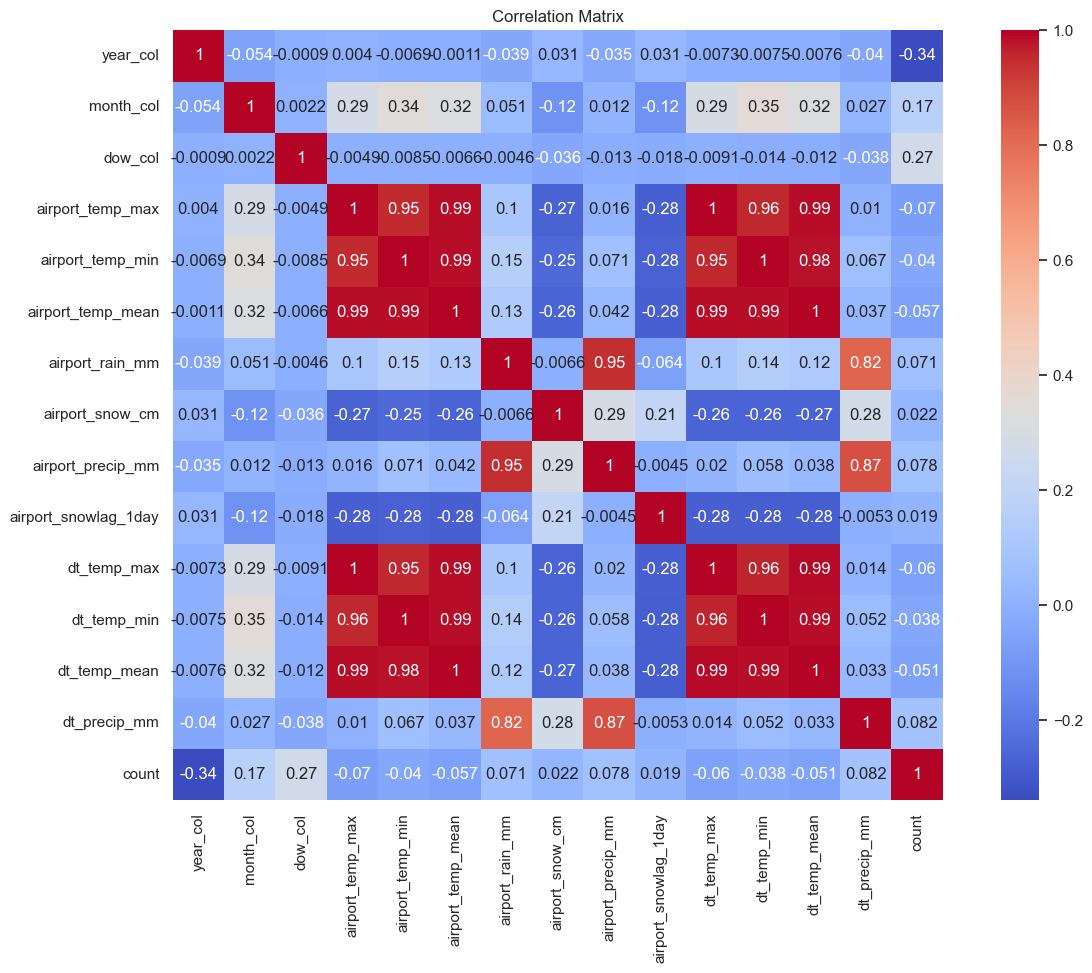

In [123]:
warnings.filterwarnings('ignore') #Ignores warnings

correlation_matrix = demand_weather.corr()

# Create a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)

# Set the title and display the plot
plt.title('Correlation Matrix')
plt.show()

In [124]:
correlation_matrix['rank'] = correlation_matrix['count'].abs().rank(ascending=False).astype(int)
correlation_matrix_rank = correlation_matrix[['count','rank']].sort_values(by='rank', ascending=True)
correlation_matrix_rank

,count,rank
count,1.000000,1
year_col,-0.338912,2
dow_col,0.271110,3
month_col,0.166392,4
dt_precip_mm,0.081960,5
airport_precip_mm,0.078469,6
airport_rain_mm,0.070924,7
airport_temp_max,-0.070369,8
dt_temp_max,-0.060230,9
airport_temp_mean,-0.056850,10


The values in the correlation matrix and the more isolated table above suggest that the temporal independent variables (eg. `year_col`, `month_col`, `dow_col`) demonstrate the moderate relationships, while the remaining weather related components have very weak relationships.

### Correlation for [Range1] Pre-pandemic: 2018-01-01 to 2020-03-13 inclusive

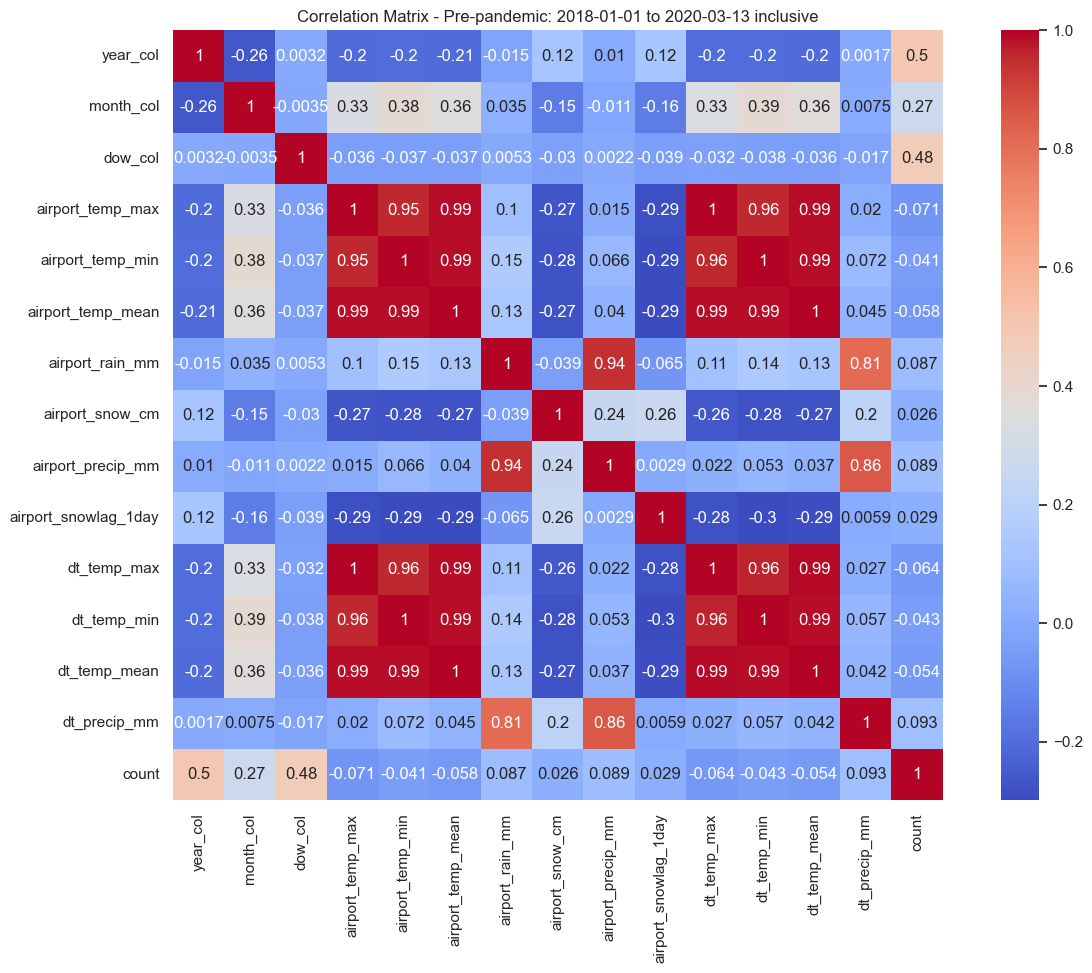

In [125]:
warnings.filterwarnings('ignore') #Ignores warnings

demand_weather_range1 = demand_weather[demand_weather['date_col'] < '2020-03-14'].dropna()
correlation_matrix_range1 = demand_weather_range1.corr()
correlation_matrix_range1

# Create a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix_range1, annot=True, cmap="coolwarm", square=True)

# Set the title and display the plot
plt.title('Correlation Matrix - Pre-pandemic: 2018-01-01 to 2020-03-13 inclusive')
plt.show()

In [126]:
correlation_matrix_range1['rank'] = correlation_matrix_range1['count'].abs().rank(ascending=False).astype(int)
correlation_matrix_range1_rank = correlation_matrix_range1[['count','rank']].sort_values(by='rank', ascending=True)
correlation_matrix_range1_rank

,count,rank
count,1.000000,1
year_col,0.498203,2
dow_col,0.476650,3
month_col,0.274205,4
dt_precip_mm,0.093178,5
airport_precip_mm,0.089432,6
airport_rain_mm,0.086558,7
airport_temp_max,-0.071201,8
dt_temp_max,-0.063615,9
airport_temp_mean,-0.057706,10


When isolating for records only within `Range1`, the correlation coefficients for the temporal independent variables improve, but the weather components continue to demonstrate weak relationships. There is an inherent relationship between temperature and month of the year.

### Correlation for [Range2] General lockdown measures: 2020-03-14 to 2021-06-10 inclusive

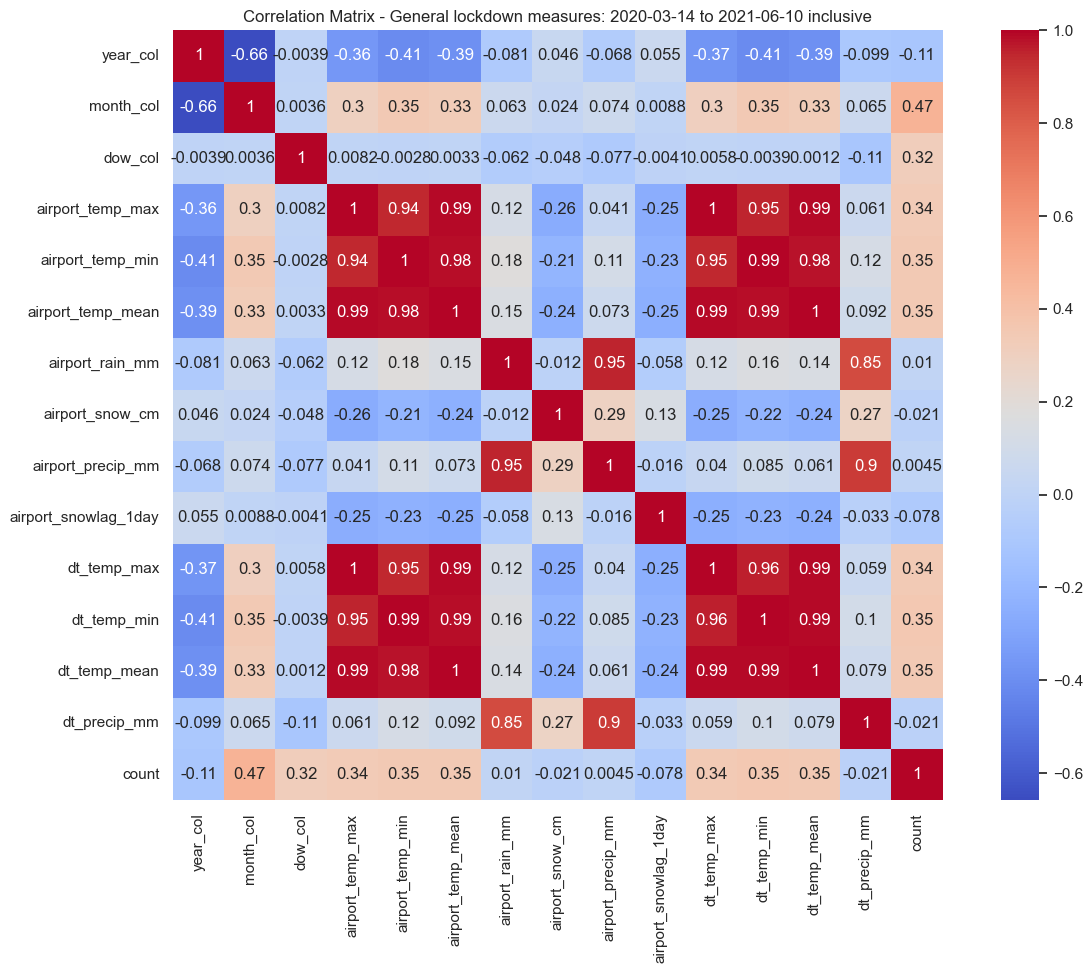

In [127]:
warnings.filterwarnings('ignore') #Ignores warnings

demand_weather_range2 = demand_weather[(demand_weather['date_col'] >= '2020-03-14') & (demand_weather['date_col'] < '2021-06-11')].dropna()
correlation_matrix_range2 = demand_weather_range2.corr()
correlation_matrix_range2

# Create a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix_range2, annot=True, cmap="coolwarm", square=True)

# Set the title and display the plot
plt.title('Correlation Matrix - General lockdown measures: 2020-03-14 to 2021-06-10 inclusive')
plt.show()

In [128]:
correlation_matrix_range2['rank'] = correlation_matrix_range2['count'].abs().rank(ascending=False).astype(int)
correlation_matrix_range2_rank = correlation_matrix_range2[['count','rank']].sort_values(by='rank', ascending=True)
correlation_matrix_range2_rank

,count,rank
count,1.000000,1
month_col,0.470767,2
dt_temp_min,0.353852,3
dt_temp_mean,0.352058,4
airport_temp_min,0.347029,5
airport_temp_mean,0.346895,6
dt_temp_max,0.343707,7
airport_temp_max,0.337698,8
dow_col,0.319671,9
year_col,-0.112877,10


In [Range2] General lockdown measures date range, temporal attributes continue to demonstrate moderate a moderate relationship. Temperature values at Pearson Airport and in Downtown Toronto have also been improved to a moderate relationship. Precipitation-related attributes remain low in its relationship with demand for services. There is an inherent relationship between temperature and month of the year.

### Correlation for [Range3] Gradual reopening: 2021-06-11 to 2022-12-31 inclusive

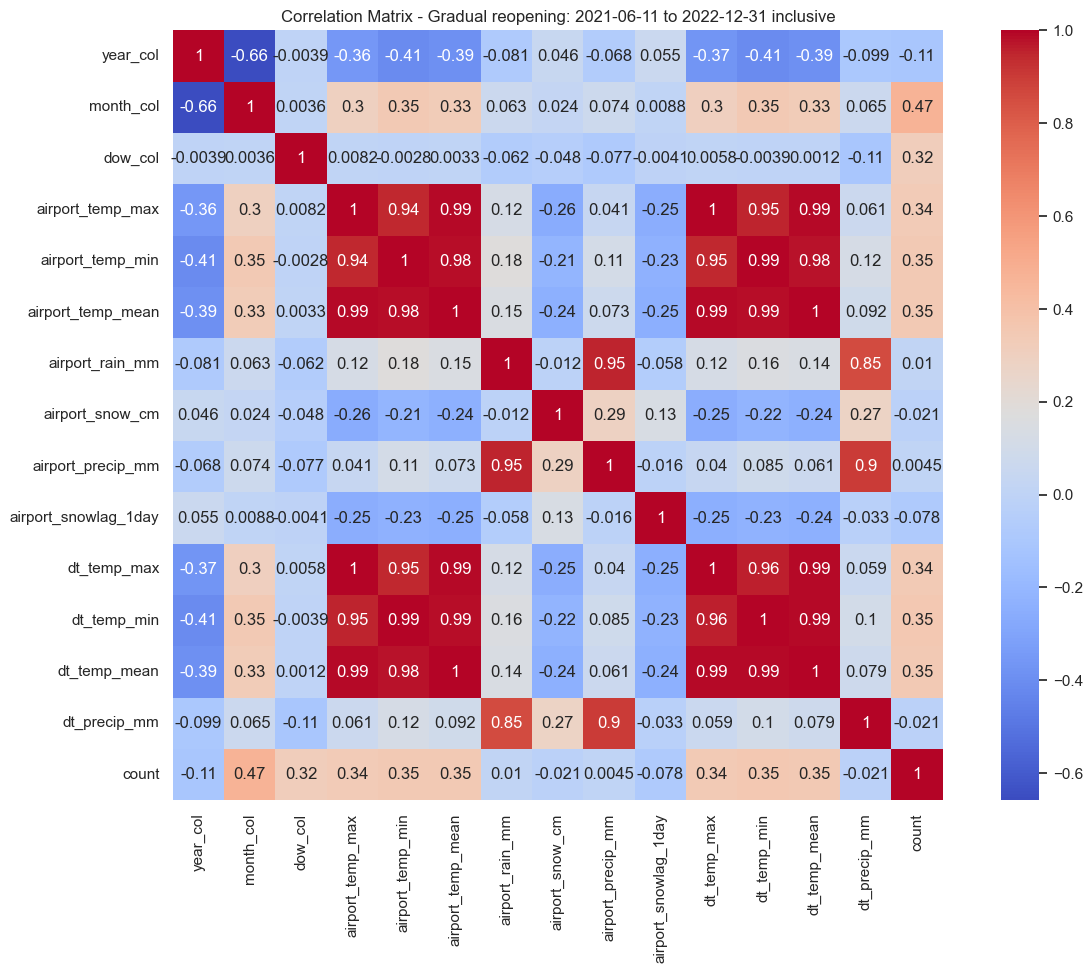

In [129]:
warnings.filterwarnings('ignore') #Ignores warnings

demand_weather_range3 = demand_weather[(demand_weather['date_col'] >= '2020-03-14') & (demand_weather['date_col'] < '2021-06-11')].dropna()
correlation_matrix_range3 = demand_weather_range3.corr()
correlation_matrix_range3

# Create a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix_range3, annot=True, cmap="coolwarm", square=True)

# Set the title and display the plot
plt.title('Correlation Matrix - Gradual reopening: 2021-06-11 to 2022-12-31 inclusive')
plt.show()

In [130]:
correlation_matrix_range2['rank'] = correlation_matrix_range2['count'].abs().rank(ascending=False).astype(int)
correlation_matrix_range2_rank = correlation_matrix_range2[['count','rank']].sort_values(by='rank', ascending=True)
correlation_matrix_range2_rank

,count,rank
count,1.000000,1
month_col,0.470767,2
dt_temp_min,0.353852,3
dt_temp_mean,0.352058,4
airport_temp_min,0.347029,5
airport_temp_mean,0.346895,6
dt_temp_max,0.343707,7
airport_temp_max,0.337698,8
dow_col,0.319671,9
year_col,-0.112877,10


Findings similar to In [Range2].

General lockdown measures date range, temporal attributes continue to demonstrate moderate a moderate relationship. Temperature values at Pearson Airport and in Downtown Toronto have also been improved to a moderate relationship. Precipitation-related attributes remain low in its relationship with demand for services. There is an inherent relationship between temperature and month of the year.

## Conclusion from correlation analysis

Beacuse there is a limited relationship with the precipitation, snow, and rain variables, they will not be used in the forecasting inputs. Also, there is already an relationship between temperature and the month of the year. To simplify the forecasting and the minimize the potential for multicollinearity, these temperature variables will also be excluded.

Forecasting will focus solely on the time-related attributes, including `year_col` `month_col`, `dow_col`.

# Time series forecasting

## Forecasting goal: Predict monthly demand for Lyft and Uber trips

The most relevant forecast for City staff is a prediction of trips on a monthly basis. Because the City obtains revenues on a per-trip basis, understanding monthly demand will help staff predict revenues over time and more effectively manage operational budgets. 

The more drilled-down research question is as follows:
- To predict monthly demand  for ride-hail services for the next 6 to 12 months



### Review of the monthly demand graph


In [131]:
# Plot the original data with no 7-day moving average
fig = px.line(
    trips_monthly,
    x='date_col', 
    y='count'
    )
    
fig.update_layout(
    title='Monthly Ridehail Trips', 
    width=1400,
    xaxis=dict(
        title='Date',
        #tickformat='%Y-%m',  # Format for displaying year and month
        dtick='M3'
    ),
    yaxis=dict(
        title='Monthly Ridehail Trips'
    )
)

# Initial lockdown annotation
fig.add_shape(
    type='line',
    x0='2020-03-14',  
    x1='2020-03-14',
    y0=0, 
    y1=6300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2020-03-14',
    y=6000000,
    text='1st lockdown',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)

# Second lockdown annotation
fig.add_shape(
    type='line',
    x0='2020-11-23',  
    x1='2020-11-23',
    y0=0, 
    y1=6300000,
    line=dict(
        color='grey',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2020-11-23',
    y=6000000,
    text='2nd lockdown',
    showarrow=False,
    font=dict(
        color='grey',
        size=12
    ),
    xanchor='left'
)

# Reopening annotation
fig.add_shape(
    type='line',
    x0='2021-06-11',  
    x1='2021-06-11',
    y0=0, 
    y1=6300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2021-06-11',
    y=6000000,
    text='Gradual reopening',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)

# Further limited travel orders annotation
fig.add_shape(
    type='line',
    x0='2022-01-05',  
    x1='2022-01-05',
    y0=0, 
    y1=6300000,
    line=dict(
        color='red',
        width=2
    )
)
# Add annotation text
fig.add_annotation(
    x='2022-01-05',
    y=6000000,
    text='Limited travel orders ',
    showarrow=False,
    font=dict(
        color='red',
        size=12
    ),
    xanchor='left'
)
fig.show()

Included static image due to issues generating the graph in Github

![ridehail_monthly.png](ridehail_monthly.png)

## Applying the ARIMA time-based model
ARIMA (Autoregressive Integrated Moving Average) is a time series forecasting model used in similar research related to forecasting ridehailing demand. It combines autoregressive (AR), differencing (I), and moving average (MA) components and was used  It is designed to capture the temporal dependencies and patterns present in time series data. The analysis follows the steps provided here: https://www.youtube.com/watch?v=_qv_7lEuiZg&t=1259s&ab_channel=Paramita

In [132]:
#Creates a dataframe of `trips_monthly` table
trips_monthly_df = pd.DataFrame(trips_monthly)
trips_monthly_df = trips_monthly_df[['date_col','count']].set_index('date_col')
trips_monthly_df

,count
date_col,
2018-01-01,3020192.0
2018-02-01,2968100.0
2018-03-01,3562090.0
2018-04-01,3685425.0
2018-05-01,3888148.0
...,...
2022-09-01,4252729.0
2022-10-01,4355329.0
2022-11-01,4260862.0


### Stationary check

The stationary check in ARIMA is important in time series modelling. It helps determine whether a time series exhibits stationarity or not. Stationarity is a key assumption for ARIMA models to work effectively. If the time series is found to be non-stationary, differencing is often applied to achieve stationarity. Differencing involves computing the differences between consecutive observations to remove trends or seasonality from the data. The differenced series is then checked for stationarity again, and the process may be repeated until a stationary series is obtained.

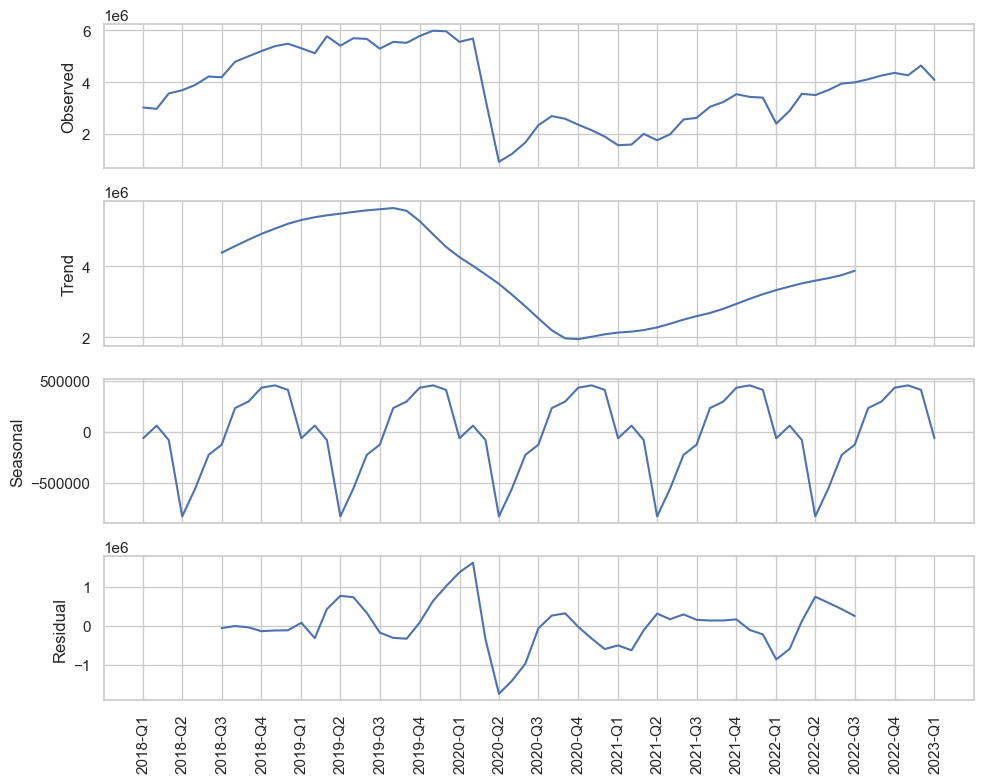

In [133]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(trips_monthly_df, model='additive')

# Set the figure size
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(10, 8), sharex=True)  # Adjust the figsize as per your preference

# Define quarter labels
quarter_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Plot each component and set labels
axes[0].set_ylabel('Observed')
axes[0].plot(trips_monthly_df.index, decomposition.observed)

axes[1].set_ylabel('Trend')
axes[1].plot(trips_monthly_df.index, decomposition.trend)

axes[2].set_ylabel('Seasonal')
axes[2].plot(trips_monthly_df.index, decomposition.seasonal)

axes[3].set_ylabel('Residual')
axes[3].plot(trips_monthly_df.index, decomposition.resid)

# Set x-axis tick locations and labels
xticks = trips_monthly_df.index[::3]  # Assuming data is monthly, set ticks at every 3rd index
xticklabels = [f'{date.year}-{quarter_labels[date.quarter-1]}' for date in xticks]
plt.xticks(ticks=xticks, labels=xticklabels, rotation=90)  # Rotate x-axis labels by 90 degrees

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot

plt.show()

### Interpreting the above graphs 
Trend graph: 
- Represents the underlying trend or long-term pattern in the data
- There is a clear trend downwards as a result of pandemic lockdowns, with a steady trend rise starting in Q4 of 2020

Seasonal graph:
- Identifies the recurring patterns and variations in the time series data that occur at regular intervals
- There is a clear regular interval occurring annually, at the lowest around Q2 and highest around Q4

Residual graph:
- Represents the residual component obtained from the seasonal decomposition of the time series graph
- There are larger swings in residuals around 2020-Q1 and 2020-Q2 due to the dramatic declines in demand with the start of the lockdowns

### Is there stationarity?
- Trend graph represents fairly large changes to demand-- meaning it is non-stationary
- Residual graph also shows similar fluctuations over time-- meaning it is non-stationary

Because the graphs are very clearly showing fluctuations (indicating non-stationarity), completing tests like the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests will not be necessary.

**Augmented Dickey Fuller Test**

The Augmented Dickey Fuller (ADF) test is test statistic used to test the null hypothesis of non-stationarity in a time series. This is a more statistical approach to augment the conclusions already made from the graphs above.

In [134]:
result = adfuller(trips_monthly_df)
print('ADF Statistic: %F' % result[0])
print('p-value: %F' % result[1])


ADF Statistic: -2.109633
p-value: 0.240659


A negative ADF statistic indicates that the differenced series of values is leading towards stationarity.

P-value that is greater than the chosen significance level of 0.05. This indicates that it is not stationary.

### Determining patterns and correlations through ACF PACF plots

ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are commonly used tools in time series analysis to identify the underlying patterns and correlations within a time series dataset.

ACF helps us see how related each value of a series is to its previous values. It shows if there is any repeating pattern or seasonality in the data. PACF is similar to ACF, but it focuses on the direct relationship between two values in a series, considering the influence of other values in between. ACF helps us see if there's a general pattern or trend in the data, while PACF helps us understand the direct connection between specific values in the series.

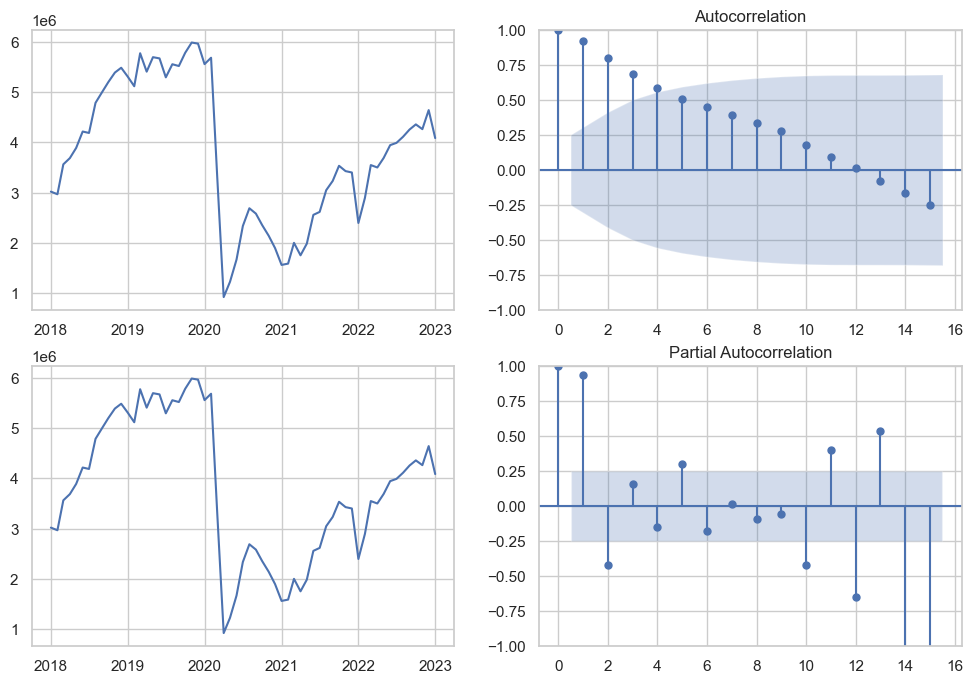

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(trips_monthly_df)
plot_acf(trips_monthly_df, lags = 15, ax=axes[0, 1])

axes[1, 0].plot(trips_monthly_df)
plot_pacf(trips_monthly_df, lags = 15, ax=axes[1, 1])

plt.show()

**Commentary of the ACF and PACF plots**

**ACF Conclusions:** As the lag increases, the decreasing pattern in the ACF plot indicates that the correlation between a data point and its previous values gradually decreases as the time gap (lag) increases.
The consistent decrease in correlation up to the 12th lag indicates a repeating yearly cycle pattern
This implies that the data exhibits a consistent pattern or trend that repeats itself every year, suggesting a yearly seasonality effect.

**PACF Conclusions:**
There does not appear to be any specific patterns from the PACF plot. ACF table indicates the presence of a yearly seasonality effect (lag-1 and lag-11) and a pattern of alternating highs and lows every four months or multiples thereof (lag-4, lag-10, lag-12, and lag-14). It is difficult to draw major conclusions from this output.



## Splitting the dataset

There are several ways to split a dataset into training and testing subsets for model evaluation:
- Time-Based Split - Split the data based on a specific point in time. 
- K-Fold Cross-Validation - Divide the data into K equal-sized folds
- Stratified split - Special cases that split the dataset based on imbalanced datasets, where the classes or target variable distribution is uneven (which is the case as a result of the pandemic)

For this deliverable scope, the time-based split will be used to execute the model. The other splitting methods will be applied in the final deliverable.

### Time-based split

As part of the first test application of the forecasting, the date ranges will be as follows:
- Training dataset: January 2018 to June 2022 (54 months)
- Testing from July 2022 to January 2023 (7 months)

In [136]:
# Splitting the dataset between `train` and `test`
train_set = trips_monthly_df[:54]
test_set = trips_monthly_df[54:]

# Because the datsaet has seasonality, we should use the seasonal ARIMA but we will still do ARIMA so we can see the differences

### Another check of correlation

In [137]:
# Duplicate the table
train_set_corr = train_set.copy()

# Reset the index
train_set_corr = train_set_corr.reset_index()

# Add year_col and month_col
train_set_corr['year_col'] = pd.to_datetime(train_set_corr['date_col']).dt.year
train_set_corr['month_col'] = pd.to_datetime(train_set_corr['date_col']).dt.month

# Remove date_col column
train_set_corr = train_set_corr.drop('date_col', axis=1)

# Reorder the columns
train_set_corr = train_set_corr[['year_col', 'month_col', 'count']]

# Display the resulting table
train_set_corr.head()

,year_col,month_col,count
0,2018,1,3020192.0
1,2018,2,2968100.0
2,2018,3,3562090.0
3,2018,4,3685425.0
4,2018,5,3888148.0


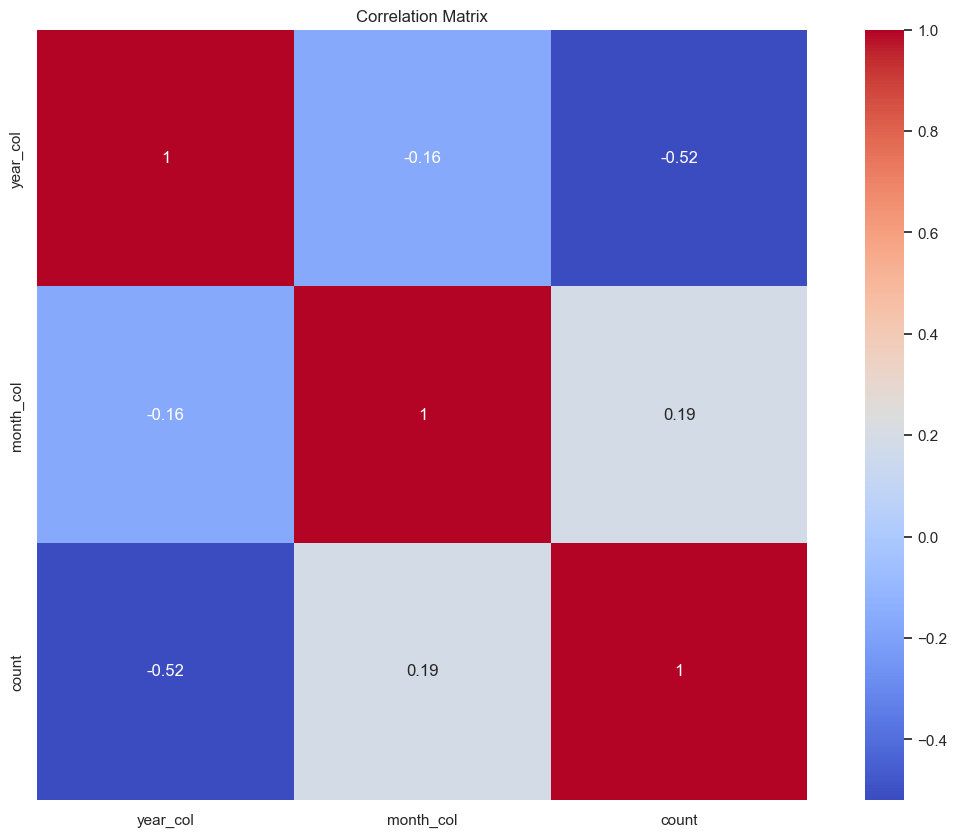

In [138]:
warnings.filterwarnings('ignore') #Ignores warnings

correlation_matrix = train_set_corr.corr()

# Create a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)

# Set the title and display the plot
plt.title('Correlation Matrix')
plt.show()

## Approach 1. Applying the ARIMA model

### Determining the ARIMA hyperparameters 

There are two approaches for determining the most optimal way of determining these hyperparameers `p`, `q`, `d`:
For loop method calculates all combinations of AR (autoregressive), I (integrated), and MA (moving average): 
1. Using Root Mean Squared Error (RMSE) for all AR, I, MA combinations
2. Using Bayesian Information Criterion (BIC) for all AR, I, MA combinations


### Approach 1A. Using Root Mean Squared Error (RMSE) for all AR, I, MA combinations

The Root Mean Squared Error is a commonly used metric for evaluating the performance of a predictive model. It measures the average magnitude of the errors between the predicted values and the actual values of a target variable. The lower the RMSE, the better.

In [139]:
# Identifies the typical ranges of p (autoregressive order), d (integrated order), q (moving average order)
p=range(0,12) #Typically values from 0 to 12
d=range(0,2)  #Typically values from 0 to 2
q=range(0,10)  #Typically values from 0 to 10

pdq_combination = list(itertools.product(p,d,q))

In [140]:
warnings.filterwarnings('ignore') #Ignores warnings

#Create empty lists for RMSE and Order
rmse=[]
order=[]

#For loop that calculates the mean squared error for each 

for pdq in pdq_combination:
    try:
        model = ARIMA(train_set, order=pdq).fit()
        prediction = model.predict(start = len(train_set),end = (len(trips_monthly_df)-1))
        error = np.sqrt(mean_squared_error(test_set, prediction))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [141]:
#Sorts the RMSE outputs from smallest to highest for each combination of b, q, d
results = pd.DataFrame(index=order, data=rmse, columns=['RMSE']).sort_values(by='RMSE', ascending=True)
results

,RMSE
"(10, 1, 4)",1.502924e+05
"(11, 1, 5)",1.506539e+05
"(7, 0, 4)",1.512867e+05
"(5, 1, 7)",1.645657e+05
"(10, 1, 6)",1.715429e+05
...,...
"(7, 1, 9)",1.101971e+06
"(10, 0, 9)",1.133311e+06
"(11, 0, 8)",1.137119e+06
"(9, 1, 9)",1.308872e+06


In [142]:
#Predicting demand in the test range period
model = ARIMA(train_set, order=(10, 1, 4))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train_set), end=(len(trips_monthly_df)-1))

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   54
Model:                ARIMA(10, 1, 4)   Log Likelihood                -771.995
Date:                Tue, 18 Jul 2023   AIC                           1573.990
Time:                        12:52:49   BIC                           1603.544
Sample:                    01-01-2018   HQIC                          1585.355
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3813      0.386      0.987      0.323      -0.376       1.138
ar.L2          1.1555      0.446      2.592      0.010       0.282       2.029
ar.L3          0.0755      0.498      0.152      0.880      -0.901       1.052
ar.L4         -0.8675      0.413     -2.102      0.036      -1.676      -0.059
ar.L5          0.1533      0.492      0.312      0.755      -0.810       1.117
ar.L6          0.0343      0.819      0.042      0.967      -1.570       1.639
ar.L7          0.1705      0.521      0.327      0.744      -0.852       1.193
ar.L8         -0.1029      0.964     -0.107      0.915      -1.991       1.786
ar.L9          0.0122      0.431      0.028      0.977      -0.833       0.858
ar.L10        -0.1046      0.580     -0.180      0.857      -1.242       1.032
ma.L1         -0.1372      0.534     -0.257      0.797      -1.183       0.909
ma.L2         -1.3452      0.466     -2.886      0.004      -2.259      -0.432
ma.L3         -0.3353      0.546     -0.615      0.539      -1.405       0.734
ma.L4          0.8823      0.463      1.904      0.057      -0.026       1.791
sigma2      3.081e+11   3.42e-12      9e+22      0.000    3.08e+11    3.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):               194.44
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -2.40
Prob(H) (two-sided):                  0.50   Kurtosis:                        11.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+39. Standard errors may be unstable.
"""

In [143]:
# Assign the index name and rename it as `date_col`
prediction.index = pd.to_datetime(prediction.index).rename('date_col')

# Calculate MSE
mse = np.mean((np.array(test_set) - np.array(prediction))**2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(np.array(test_set) - np.array(prediction)))

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 215055.54554207914
MSE: 46248887668.401276
MAE: 172352.31855503758


In [144]:
mean_val = test_set.mean().item()
stdev = np.sqrt(test_set.var()).item()

print('Mean: %F'  % mean_val)
print('Standard deviation: %F' % stdev)

# print('ADF Statistic: %F' % result[0])
# print('p-value: %F' % result[1])

#Determining the mean squared error
error = np.sqrt(mean_squared_error(test_set, prediction))
print('Error: %F'  % error)


Mean: 4241221.000000
Standard deviation: 215230.138641
Error: 150292.397805


**Conclusion**

The mean squared error is more than one standard deviation from the mean of the test dataset. When the mean squared error (MSE) is more than one standard deviation from the mean of the test dataset, it does not necessarily indicate that it is a good fit. Generally, a lower MSE indicates that the model's predictions are closer to the actual values, while a higher MSE indicates larger prediction errors.

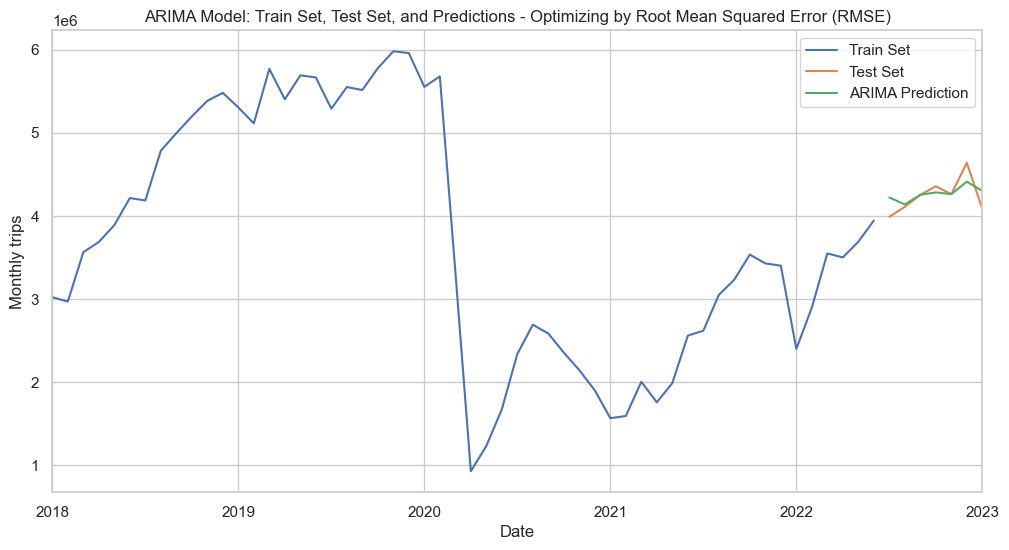

In [145]:
# Concatenate train_set, test_set, and predictions into a single DataFrame
data = pd.concat([train_set, test_set, prediction], axis=1)
data.columns = ['Train Set', 'Test Set', 'ARIMA Prediction']

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize parameter as per your desired size

# Plot the data
data.plot(legend=True, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Train Set, Test Set, and Predictions - Optimizing by Root Mean Squared Error (RMSE)')
plt.show()


**Commentary of the ARIMA Prediction**

The ARIMA prediction above fit the observed values fairly well. However that might be a result of the optimization of b, q, d values. Overall, the ARIMA prediction was slightly smoother than the observed test set results.

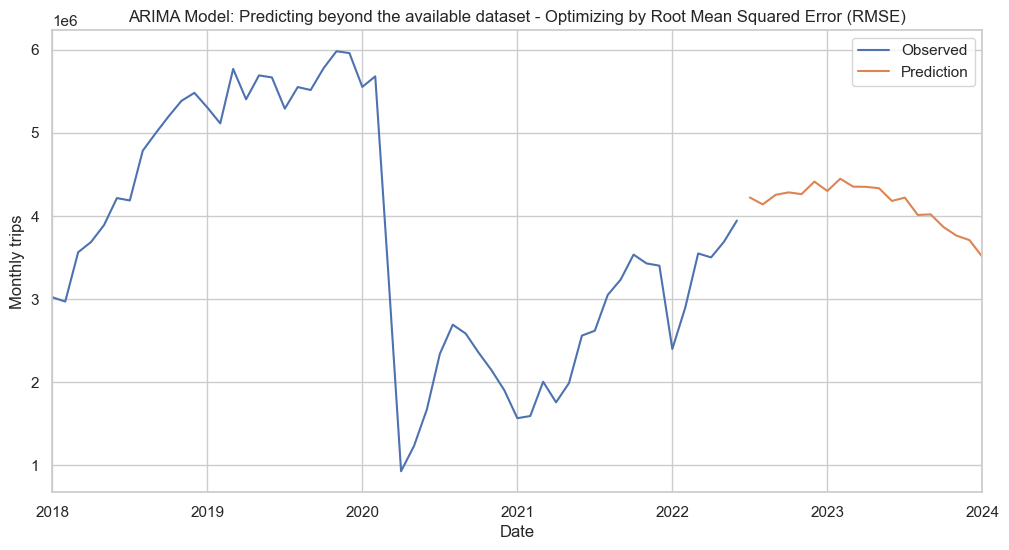

In [146]:
final_model = ARIMA(train_set, order=(10, 1, 4)).fit()  # Build the ARIMA model beyond the available data
prediction_future = final_model.predict(len(train_set), len(train_set) + 18)

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data and predictions
train_set.plot(legend=True, ax=ax)
prediction_future.plot(legend=True, ax=ax)

# Customize the x-axis, y-axis, and chart title
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Predicting beyond the available dataset - Optimizing by Root Mean Squared Error (RMSE)')
# Update legend labels
ax.legend(labels=['Observed', 'Prediction'])

plt.show()

**Commentary of the ARIMA prediction beyond the test set**

The prediction beyond the test set using the same modelling parameters shows a decline in demand for the whole of 2023. This is not accurate as the City continues to rebound from the pandemic. However, due to the declines in observed demand in 2020 and 2021, this has affected the prediction into 2023.

### Approach 1B. Using Bayesian Information Criterion (BIC) for all AR, I, MA combinations

Information criteria, such as the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC), can be used to compare different ARIMA models. Lower values of AIC or BIC indicate a better fit, considering both the model's goodness of fit and its complexity.

- AIC is suitable when the emphasis is on finding the best predictive model, even if it is more complex. 
- BIC is more appropriate when the emphasis is on finding a simpler model with good predictive performance and avoiding overfitting.

Based on these conditions, BIC is more appropriate in this case that balances performance without overfitting.

In [147]:
# Identifies the typical ranges of p (autoregressive order), q (moving average order), d (integrated order)

pdq_combination.clear()
order.clear()

p = range(0, 12)
q = range(0, 10)
d = range(0, 2)

pdq_combination = list(itertools.product(p, d, q))

# Create empty lists for BIC
bic = []

# For loop that calculates the BIC for each combination
for pdq in pdq_combination:
    try:
        model = ARIMA(train_set, order=pdq).fit()
        bic_value = model.bic
        order.append(pdq)
        bic.append(bic_value)
    except:
        continue

# Sort the BIC values from smallest to highest for each combination of p, d, q
results = pd.DataFrame(index=order, data=bic, columns=['BIC']).sort_values(by='BIC', ascending=True)
results

,BIC
"(0, 1, 0)",1559.714936
"(1, 1, 0)",1560.641330
"(0, 1, 1)",1560.704711
"(1, 1, 1)",1564.601285
"(2, 1, 0)",1564.648746
...,...
"(0, 0, 1)",1658.438232
"(0, 0, 8)",1666.430016
"(0, 0, 9)",1671.094128
"(11, 1, 9)",1686.842965


In [148]:
#Predicting demand in the test range period
model = ARIMA(train_set, order=(0,1,0))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train_set), end=(len(trips_monthly_df)-1))

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   54
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -777.872
Date:                Tue, 18 Jul 2023   AIC                           1557.745
Time:                        12:54:42   BIC                           1559.715
Sample:                    01-01-2018   HQIC                          1558.502
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.217e+11   2.66e+10     12.080      0.000     2.7e+11    3.74e+11
===================================================================================
Ljung-Box (L1) (Q):                   5.04   Jarque-Bera (JB):               242.05
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -2.71
Prob(H) (two-sided):                  0.38   Kurtosis:                        11.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
# Assign the index name and rename it as `date_col`
prediction.index = pd.to_datetime(prediction.index).rename('date_col')

# Calculate MSE
mse = np.mean((np.array(test_set) - np.array(prediction))**2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(np.array(test_set) - np.array(prediction)))

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 358447.5838189495
MSE: 128484670345.64285
MAE: 297957.0


In [150]:
#Model evaluation
mean_val = test_set.mean().item()
stdev = np.sqrt(test_set.var()).item()

print('Mean: %F'  % mean_val)
print('Standard deviation: %F' % stdev)

# print('ADF Statistic: %F' % result[0])
# print('p-value: %F' % result[1])

#Determining the mean squared error
error = np.sqrt(mean_squared_error(test_set, prediction))
print('Error: %F'  % error)


Mean: 4241221.000000
Standard deviation: 215230.138641
Error: 358447.583819


**Conclusion**

Similar to Method 1A, the mean squared error is more than one standard deviation from the mean of the test dataset. When the mean squared error (MSE) is more than one standard deviation from the mean of the test dataset, it does not necessarily indicate that it is a good fit. Generally, a lower MSE indicates that the model's predictions are closer to the actual values, while a higher MSE indicates larger prediction errors.

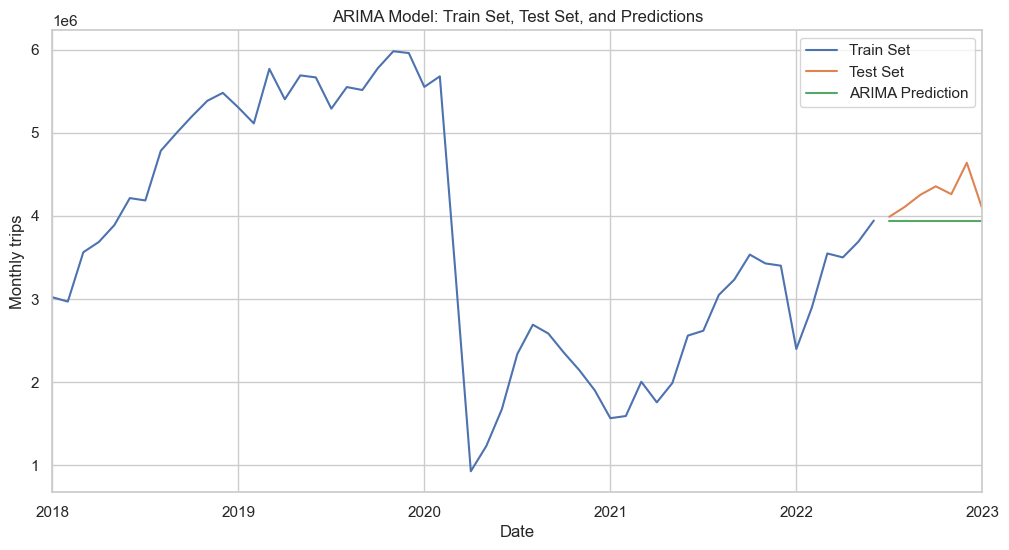

In [151]:
# Concatenate train_set, test_set, and predictions into a single DataFrame
data = pd.concat([train_set, test_set, prediction], axis=1)
data.columns = ['Train Set', 'Test Set', 'ARIMA Prediction']

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize parameter as per your desired size

# Plot the data
data.plot(legend=True, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Train Set, Test Set, and Predictions')
plt.show()


**Commentary of the ARIMA Prediction**

As shown in the graph above, it failed to properly predict demand temporally beyond the test set. When an ARIMA prediction is completely flat, it means that the model is not capturing any trend or seasonality in the data. This typically occurs when the ARIMA model fails to adequately capture the underlying patterns or dynamics of the time series. It might be due to:
- insufficient order selection of (p, d, q) values, 
- the time series exhibiting season patterns (to which SARIMA is more suitable)
- high level of noise in the data

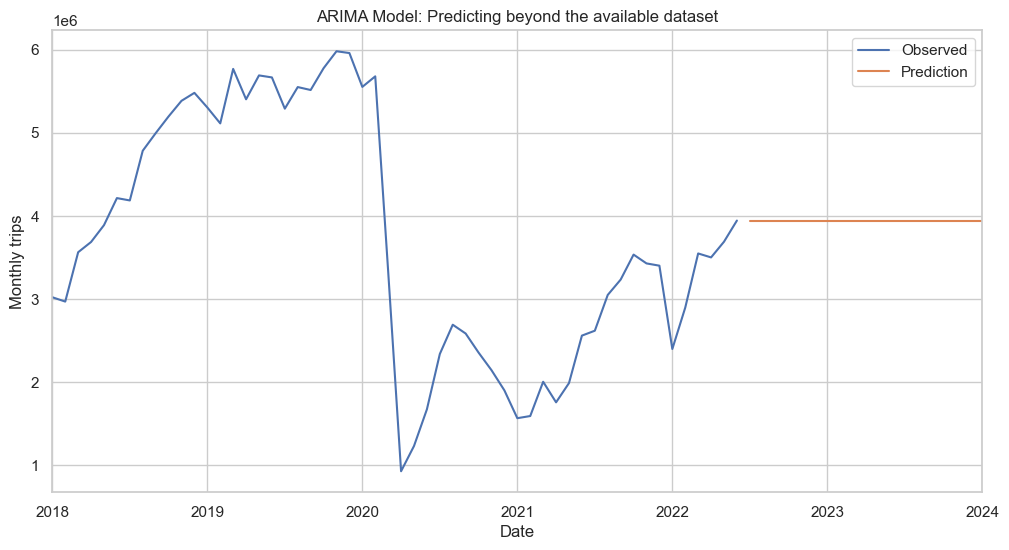

In [152]:
final_model = ARIMA(train_set, order=(0, 1, 0)).fit()  # Build the ARIMA model beyond the available data
prediction_future = final_model.predict(len(train_set), len(train_set) + 18)

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data and predictions
train_set.plot(legend=True, ax=ax)
prediction_future.plot(legend=True, ax=ax)

# Customize the x-axis, y-axis, and chart title
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Predicting beyond the available dataset')

# Update legend labels
ax.legend(labels=['Observed', 'Prediction'])

plt.show()

**Commentary of the ARIMA prediction beyond the test set**

As shown in the graph above, it failed to properly predict demand temporally beyond the test set and into 2023.

# Conclusions and next steps leading up to the 2023-06-30 deliverable

As demonstrated from the modelling progress so far, there is still some further improvement that could be applied to improve the results. Here are the next steps to pursue to potentially improve the results:

- Explore how Seasonal ARIMA might help to improve on the existing models
- Removing the pandemic observations to improve the performance of the model

## Approach 2 Applying the SARIMA model
### Determining the ARIMA hyperparameters 
### Approach 2A. Optimizing for Root Mean Squared Error (RMSE) for all AR, I, MA combinations

In [153]:
# Identifies the typical ranges of p (autoregressive order), q (moving average order), d (integrated order)
# %%script false # Skips running this code due to long runtime

p = range(0, 12)
q = range(0, 10)
d = range(0, 2)
s = 12

pdq_combination = list(itertools.product(p, d, q))

In [180]:
# %%script false # Skips running this code due to long runtime
# warnings.filterwarnings('ignore') #Ignores warnings

#Create empty lists for RMSE and Order
rmse=[]
order=[]

#For loop that calculates the mean squared error for each 

for pdq in pdq_combination:
    try:
        model = SARIMAX(train_set, order=(10,1,4), seasonal_order=(*pdq, s)).fit()
        prediction = model.predict(start = len(train_set),end = len(trips_monthly_df)-1)
        error = np.sqrt(mean_squared_error(test_set, prediction))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [181]:
#Sorts the RMSE outputs from smallest to highest for each combination of b, q, d
results_rmse_add = pd.DataFrame(index=order, data=rmse, columns=['RMSE']).sort_values(by='RMSE', ascending=True)
results_rmse_add

,RMSE
"(0, 0, 0)",150292.397805
"(0, 0, 1)",156753.734829
"(0, 0, 2)",177906.073223
"(2, 0, 0)",183938.027934
"(1, 0, 3)",215353.860071
...,...
"(5, 0, 9)",782769.828038
"(10, 0, 3)",786118.308081
"(5, 0, 1)",789394.607476
"(6, 0, 1)",790018.362285


In [182]:
# #Exported the table due to the long time needed to determine the BIC values for all B, Q, D values
# %%script false # Skips running this code due to long runtime
results_rmse_add.reset_index().to_csv('rmse_results_noremovals.csv', index=False) #RMSE for loop results

In [183]:
# # Read the CSV file into a DataFrame
results_rmse_add = pd.read_csv('rmse_results_noremovals.csv')

In [184]:
arima_order = (10, 1, 4) #Based on the ARIMA optimization above
sarima_order = (0, 0, 0, 12)
sarima_model_fit = SARIMAX(train_set, order=arima_order, seasonal_order=sarima_order).fit()
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   54
Model:              SARIMAX(10, 1, 4)   Log Likelihood                -771.995
Date:                Tue, 18 Jul 2023   AIC                           1573.990
Time:                        18:52:35   BIC                           1603.544
Sample:                    01-01-2018   HQIC                          1585.355
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3813      0.386      0.987      0.323      -0.376       1.138
ar.L2          1.1555      0.446      2.592      0.010       0.282       2.029
ar.L3          0.0755      0.498      0.152      0.880      -0.901       1.052
ar.L4         -0.8675      0.413     -2.102      0.036      -1.676      -0.059
ar.L5          0.1533      0.492      0.312      0.755      -0.810       1.117
ar.L6          0.0343      0.819      0.042      0.967      -1.570       1.639
ar.L7          0.1705      0.521      0.327      0.744      -0.852       1.193
ar.L8         -0.1029      0.964     -0.107      0.915      -1.991       1.786
ar.L9          0.0122      0.431      0.028      0.977      -0.833       0.858
ar.L10        -0.1046      0.580     -0.180      0.857      -1.242       1.032
ma.L1         -0.1372      0.534     -0.257      0.797      -1.183       0.909
ma.L2         -1.3452      0.466     -2.886      0.004      -2.259      -0.432
ma.L3         -0.3353      0.546     -0.615      0.539      -1.405       0.734
ma.L4          0.8823      0.463      1.904      0.057      -0.026       1.791
sigma2      3.081e+11   3.42e-12      9e+22      0.000    3.08e+11    3.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):               194.44
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -2.40
Prob(H) (two-sided):                  0.50   Kurtosis:                        11.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+39. Standard errors may be unstable.
"""

**Interpretation**

None of the covariance items show a p-value of less than 0.05, therefore they are not statistically significant.

**Predicting using the model**

In [192]:
prediction = pd.DataFrame(sarima_model_fit.forecast(len(test_set)))

# Assign the index name and rename it as `date_col`
prediction.index = pd.to_datetime(prediction.index).rename('date_col')

# Display the DataFrame with the assigned index
prediction


,predicted_mean
date_col,
2022-07-01,4.220648e+06
2022-08-01,4.137772e+06
2022-09-01,4.252792e+06
2022-10-01,4.282351e+06
2022-11-01,4.260981e+06
2022-12-01,4.411807e+06
2023-01-01,4.299164e+06


In [161]:
# Calculate MSE
mse = np.mean((np.array(test_set) - np.array(prediction))**2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(np.array(test_set) - np.array(prediction)))

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 150292.39780498878
MSE: 22587804837.972996
MAE: 111006.3945398763


In [185]:
#Model evaluation
mean_val = test_set.mean().item()
stdev = np.sqrt(test_set.var()).item()

print('Mean: %F'  % mean_val)
print('Standard deviation: %F' % stdev)

# print('ADF Statistic: %F' % result[0])
# print('p-value: %F' % result[1])

#Determining the mean squared error
error = np.sqrt(mean_squared_error(test_set, prediction))
print('Error: %F'  % error)

Mean: 4241221.000000
Standard deviation: 215230.138641
Error: 625125.134898


**Analyzing the residuals**

Text(0, 0.5, 'Error')

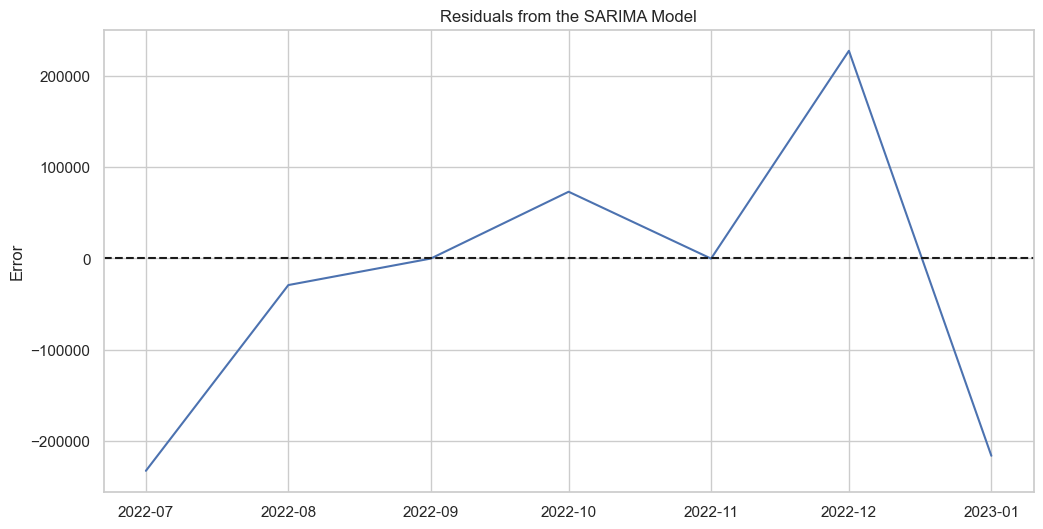

In [194]:
#Get the residuals
residuals = test_set['count'] - prediction['predicted_mean']
# residuals
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.axhline(0,linestyle='--', color='k')
plt.title('Residuals from the SARIMA Model')
plt.ylabel('Error')

**Graphing the prediction**

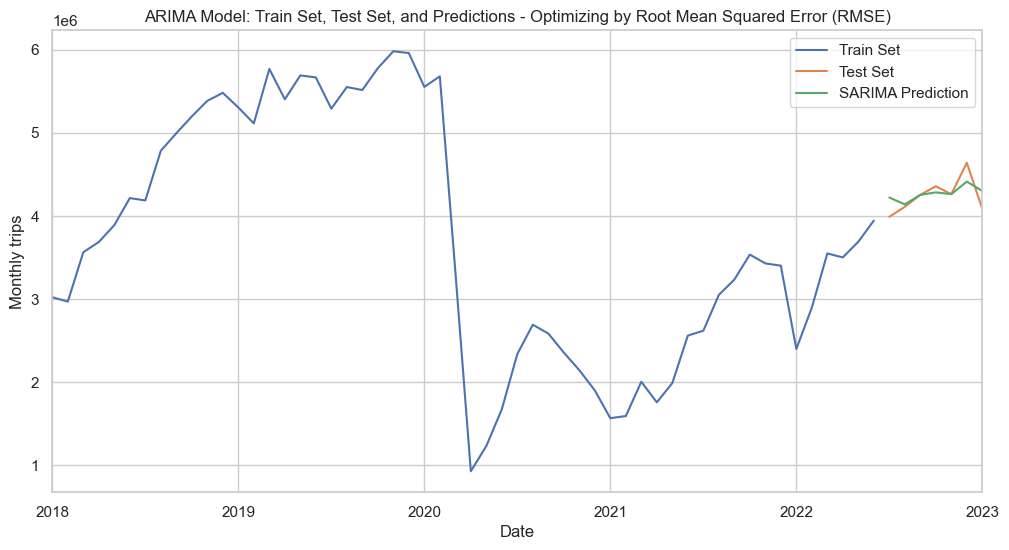

In [195]:
# Concatenate train_set, test_set, and predictions into a single DataFrame
data = pd.concat([train_set, test_set, prediction], axis=1)
data.columns = ['Train Set', 'Test Set', 'SARIMA Prediction']

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize parameter as per your desired size

# Plot the data
data.plot(legend=True, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Train Set, Test Set, and Predictions - Optimizing by Root Mean Squared Error (RMSE)')
plt.show()

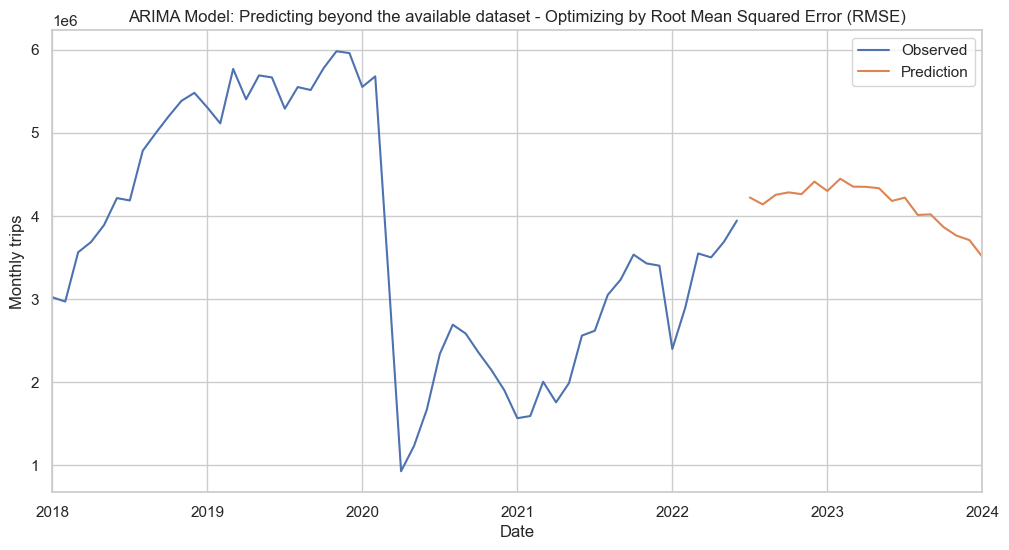

In [196]:
arima_order = (10, 1, 4) #Based on the ARIMA optimization above
sarima_order = (0, 0, 0, 12)
final_model = SARIMAX(train_set, order=arima_order, seasonal_order=sarima_order).fit()

prediction_future = final_model.predict(len(train_set), len(train_set) + 18)

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data and predictions
train_set.plot(legend=True, ax=ax)
prediction_future.plot(legend=True, ax=ax)

# Customize the x-axis, y-axis, and chart title
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Predicting beyond the available dataset - Optimizing by Root Mean Squared Error (RMSE)')
# Update legend labels
ax.legend(labels=['Observed', 'Prediction'])

plt.show()

### Approach 2B. Optimizing for Bayesian Information Criterion (BIC) for all AR, I, MA combinations

In [165]:
# Identifies the typical ranges of p (autoregressive order), q (moving average order), d (integrated order)
# %%script false # Skips running this code due to long runtime

bic.clear()
order.clear()

p = range(0, 12)
q = range(0, 10)
d = range(0, 2)
s = 12

pdq_combination = list(itertools.product(p, d, q))

In [166]:
# For loop that calculates the BIC for each combination
# %%script false # Skips running this code due to long runtime

for pdq in pdq_combination:
    try:
        model = SARIMAX(train_set, order=(0, 1, 0), seasonal_order=(*pdq, s)).fit()
        bic_value = model.bic
        order.append(pdq)
        bic.append(bic_value)
    except:
        continue

In [167]:
# Sort the BIC values from smallest to highest for each combination of p, d, q
results_bic_add = pd.DataFrame(index=order, data=bic, columns=['BIC']).sort_values(by='BIC', ascending=True)
results_bic_add

,BIC
"(1, 1, 1)",1.233448e+03
"(0, 1, 2)",1.236086e+03
"(0, 1, 3)",1.238585e+03
"(1, 1, 2)",1.238895e+03
"(1, 1, 0)",1.239183e+03
...,...
"(11, 0, 9)",1.635067e+03
"(3, 0, 0)",1.643549e+03
"(4, 0, 0)",1.655026e+03
"(3, 1, 1)",2.301762e+03


In [168]:
# %%script false # Skips running this code due to long runtime
#Exported the table due to the long time needed to determine the BIC values for all B, Q, D values
results_bic_add.reset_index().to_csv('bic_results_noremovals.csv', index=False) #BIC for loop results

In [169]:
# Read the CSV file into a DataFrame
results_bic_add = pd.read_csv('bic_results_noremovals.csv')

In [177]:
arima_order = (0, 1, 0) #Based on the ARIMA optimization above
sarima_order = (1, 1, 1, 12)
sarima_model_fit = SARIMAX(train_set, order=arima_order, seasonal_order=sarima_order).fit()
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                   54
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -611.153
Date:                              Tue, 18 Jul 2023   AIC                           1228.307
Time:                                      16:57:57   BIC                           1233.448
Sample:                                  01-01-2018   HQIC                          1230.179
                                       - 06-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1924      0.123      1.565      0.118      -0.049       0.433
ma.S.L12      -1.0000      0.117     -8.545      0.000      -1.229      -0.771
sigma2      4.044e+11   2.89e-13    1.4e+24      0.000    4.04e+11    4.04e+11
===================================================================================
Ljung-Box (L1) (Q):                   4.26   Jarque-Bera (JB):                61.96
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -1.84
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.35e+38. Standard errors may be unstable.
"""

**Interpretation**

The covariance items show a p-value of less than 0.05, therefore they are statistically significant.

**Predicting using the model**

In [171]:
prediction = pd.DataFrame(sarima_model_fit.forecast(len(test_set)))

# Assign the index name and rename it as `date_col`
prediction.index = pd.to_datetime(prediction.index).rename('date_col')

# Display the DataFrame with the assigned index
prediction


,predicted_mean
date_col,
2022-07-01,3.839715e+06
2022-08-01,4.178142e+06
2022-09-01,4.226824e+06
2022-10-01,4.460784e+06
2022-11-01,4.500069e+06
2022-12-01,4.456076e+06
2023-01-01,3.810582e+06


In [172]:
# Calculate MSE
mse = np.mean((np.array(test_set['count']) - np.array(prediction['predicted_mean']))**2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(np.array(test_set) - np.array(prediction)))

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 170659.6463301251
MSE: 29124714885.523384
MAE: 149215.66442119083


In [197]:
mean_val = test_set.mean().item()
stdev = np.sqrt(test_set.var()).item()

print('Mean: %F'  % mean_val)
print('Standard deviation: %F' % stdev)

# print('ADF Statistic: %F' % result[0])
# print('p-value: %F' % result[1])

#Determining the mean squared error
error = np.sqrt(mean_squared_error(test_set, prediction))
print('Error: %F'  % error)

Mean: 4241221.000000
Standard deviation: 215230.138641
Error: 150292.397805


**Analyzing the residuals**

Text(0, 0.5, 'Error')

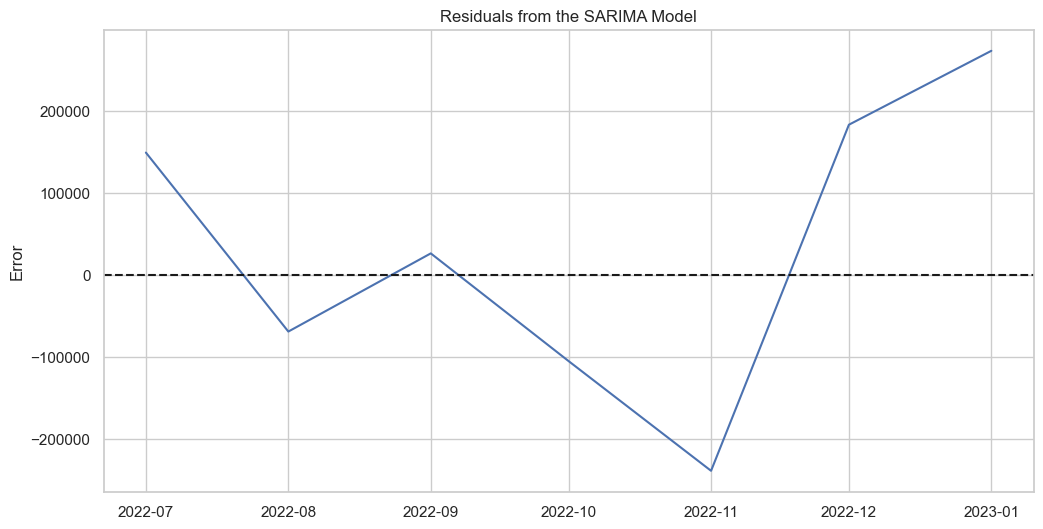

In [173]:
#Get the residuals
residuals = test_set['count'] - prediction['predicted_mean']
# residuals
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.axhline(0,linestyle='--', color='k')
plt.title('Residuals from the SARIMA Model')
plt.ylabel('Error')

**Graphing the prediction**

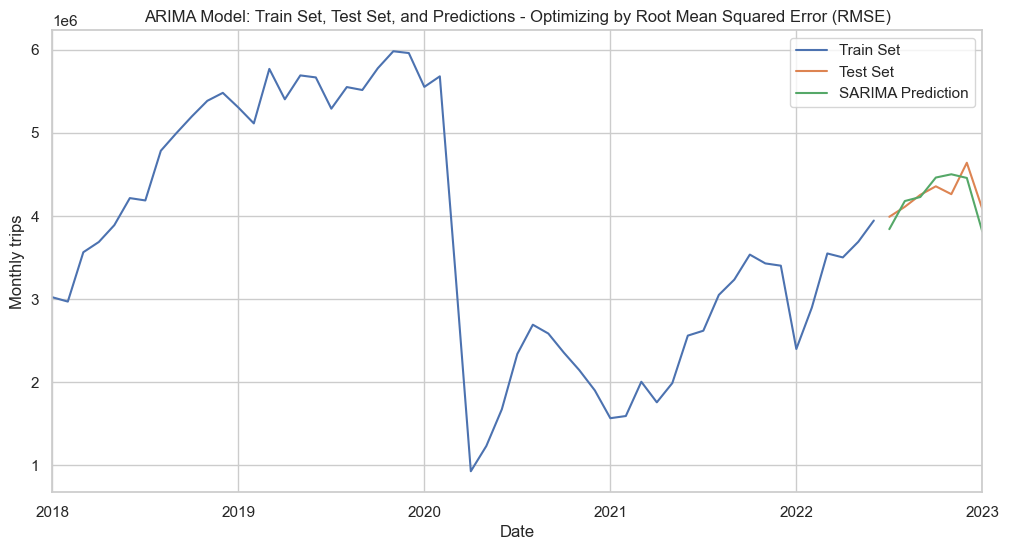

In [174]:
# Concatenate train_set, test_set, and predictions into a single DataFrame
data = pd.concat([train_set, test_set, prediction], axis=1)
data.columns = ['Train Set', 'Test Set', 'SARIMA Prediction']

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize parameter as per your desired size

# Plot the data
data.plot(legend=True, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Train Set, Test Set, and Predictions - Optimizing by Root Mean Squared Error (RMSE)')
plt.show()

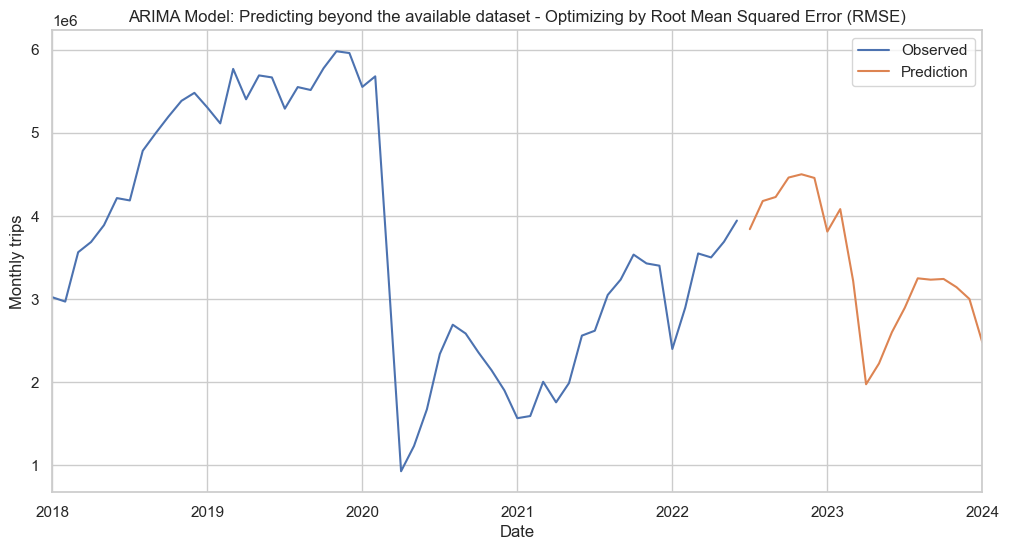

In [175]:
arima_order = (0, 1, 0) #Based on the ARIMA optimization above
sarima_order = (2, 1, 0, 12)
final_model = SARIMAX(train_set, order=arima_order, seasonal_order=sarima_order).fit()

prediction_future = final_model.predict(len(train_set), len(train_set) + 18)

# Create a figure and axes with specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data and predictions
train_set.plot(legend=True, ax=ax)
prediction_future.plot(legend=True, ax=ax)

# Customize the x-axis, y-axis, and chart title
ax.set_xlabel('Date')
ax.set_ylabel('Monthly trips')
ax.set_title('ARIMA Model: Predicting beyond the available dataset - Optimizing by Root Mean Squared Error (RMSE)')
# Update legend labels
ax.legend(labels=['Observed', 'Prediction'])

plt.show()

# Conclusions
There are four approaches taken with the time-series modelling:
- Approach 1A. ARIMA Model - Optimizing for Root Mean Squared Error (RMSE) 
- Approach 1B. ARIMA Model - Optimizing for Bayesian Information Criterion (BIC)
- Approach 2A. SARIMA Model - Optimizing for Root Mean Squared Error (RMSE) 
- Approach 2B. SARIMA Model - Optimizing for Bayesian Information Criterion (BIC)


| Major indices | Approach 1A | Approach 1B | Approach 2A | Approach 2B |
| --- | ---:| ---:| ---:| ---:|
| **Hyperparameters** | | | | |
| (p, d, q) |  (10, 1, 4) |  (0, 1, 0) |  (10, 1, 4) |  (0, 1, 0) |
| (P, D, Q, S) |  [N/A] |  [N/A] |  (0, 0, 0, 12) |  (1, 1, 1, 12) |
| **Major Parameters** | | | | |
| RMSE |  215,055.55 |  358,447.58 |  150,292.40 |  170,659.65 |
| MSE |  4.62E+10 |  1.28E+11 |  2.26E+10 |  2.91E+10 |
| MAE |  172,352.32 |  297,957.00 |  111,006.39 |  149,215.66 |
| AIC |  1,573.99 |  1,557.75 |  1,573.99 |  1,228.31 |
| BIC |  1,603.54 |  1,559.72 |  1,603.54 |  1,233.45 |
| Mean |  4,241,221.00 |  4,241,221.00 |  4,241,221.00 |  4,241,221.00 |
| Stdev |  215,230.14 |  215,230.14 |  215,230.14 |  215,230.14 |
| Error |  150,292.40 |  358,447.58 |  625,125.13 |  150,292.40 |
| Stability |  High |  High |  High |  High |
| Effectiveness (in minutes of processing) |  0.0 |  0.0 |  0.0 |  0.0 |
| Valid Predictions |  Yes |  No |  Yes |  No |
| Rank |  2 |  4 |  1 |  3 |


How to interpret the major indices:
1. Root Mean Squared Error (RMSE):
    - RMSE measures the average magnitude of the differences between predicted values and actual values.
    - It provides a measure of the model's accuracy in the same unit as the target variable.
    - Lower RMSE values indicate better model performance, as it means the model's predictions are closer to the actual values.
2. Mean Squared Error (MSE):
    - MSE is similar to RMSE, but it is not on the same scale as the target variable because it squares the differences.
    - It measures the average squared differences between predicted values and actual values.
    - Like RMSE, lower MSE values indicate better model performance, with a score of 0 indicating a perfect fit.
3. Mean Absolute Error (MAE):
    - MAE calculates the average absolute differences between predicted values and actual values.
    - It provides a measure of the average magnitude of errors without considering their direction.
    - Lower MAE values indicate better model performance, with a score of 0 indicating a perfect fit.
4. Akaike Information Criterion (AIC):
    - AIC is a measure of the goodness of fit of a statistical model.
    - It balances the model's fit to the data and the model's complexity.
    - Lower AIC values indicate a better trade-off between model fit and complexity. Models with lower AIC values are generally preferred.
5. Bayesian Information Criterion (BIC):
    - BIC is similar to AIC but places a stronger penalty on model complexity.
    - It also considers the sample size when assessing model fit.
    - Lower BIC values indicate a better trade-off between model fit, complexity, and sample size.

In terms of AIC and BIC, Approach 2B demonstrates the best fit. In terms of statistical indices like RMSE, MSE, and MAE, Approach 2A fared the best for fit.